In [1]:
import glob
import os
from collections import Counter
from itertools import combinations, product

import numpy as np
np.random.seed(18012023)

import pandas as pd
pd.set_option('display.max_colwidth', 0)

import seaborn as sb

from sklearn.metrics import pairwise_distances
import lxml.etree
from scipy.spatial.distance import pdist, squareform
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, precision_score, recall_score, \
                            precision_recall_curve, average_precision_score, \
                            roc_auc_score
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.family'] = 'Arial'
from IPython.display import display

In /Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases

## Loading and preprocessing

##### Length distribution of the intertexts

In [2]:
intertexts = pd.read_excel('../data/intertexts.xlsx')
print(len(intertexts))
intertexts.sample(5)

229


,ID,source,src-passage,target,trg-passage,verse-length,biblio,remarks
97,mor-mou-16,Moriaen,Hie deetse bat achtergaen.,Riddere metter mouwen,Ende dadense also achtergaen.,1,Van der Stempel 1930,Editions have achterstaen. Might not be a link.
145,lan-ele-21,Lantsloot van der Haghedochte,Mar ic segghe v dat ic v rade Omme te bescuwene meere scade:,Moriaen,oft gi werken wilt bi rade Ende scuwen wilt vwe scade.,2,"Heeroma 1973b, Moriaen (II)",NaN
8,mor-ele-9,Moriaen,God hi mach v wel gesterken.,Karel ende Elegast,Nv so moetti - God - mi gestercken:,1,"Heeroma 1973a, Moriaen (I)",NaN
84,mor-mou-4,Moriaen,Doe hi achters van u sciet,Riddere metter mouwen,Doe hi achters van hem sciet,1,Van der Stempel 1917,Double case
25,mor-ele-26,Moriaen,En ontfinc noit vlecge no scard.,Karel ende Elegast,Ende ontfingen scarde ende vlegghen:,1,"Heeroma 1973a, Moriaen (I)",NaN


In [3]:
fig_dir = '../figures'
if not os.path.isdir(fig_dir):
    os.mkdir(fig_dir)

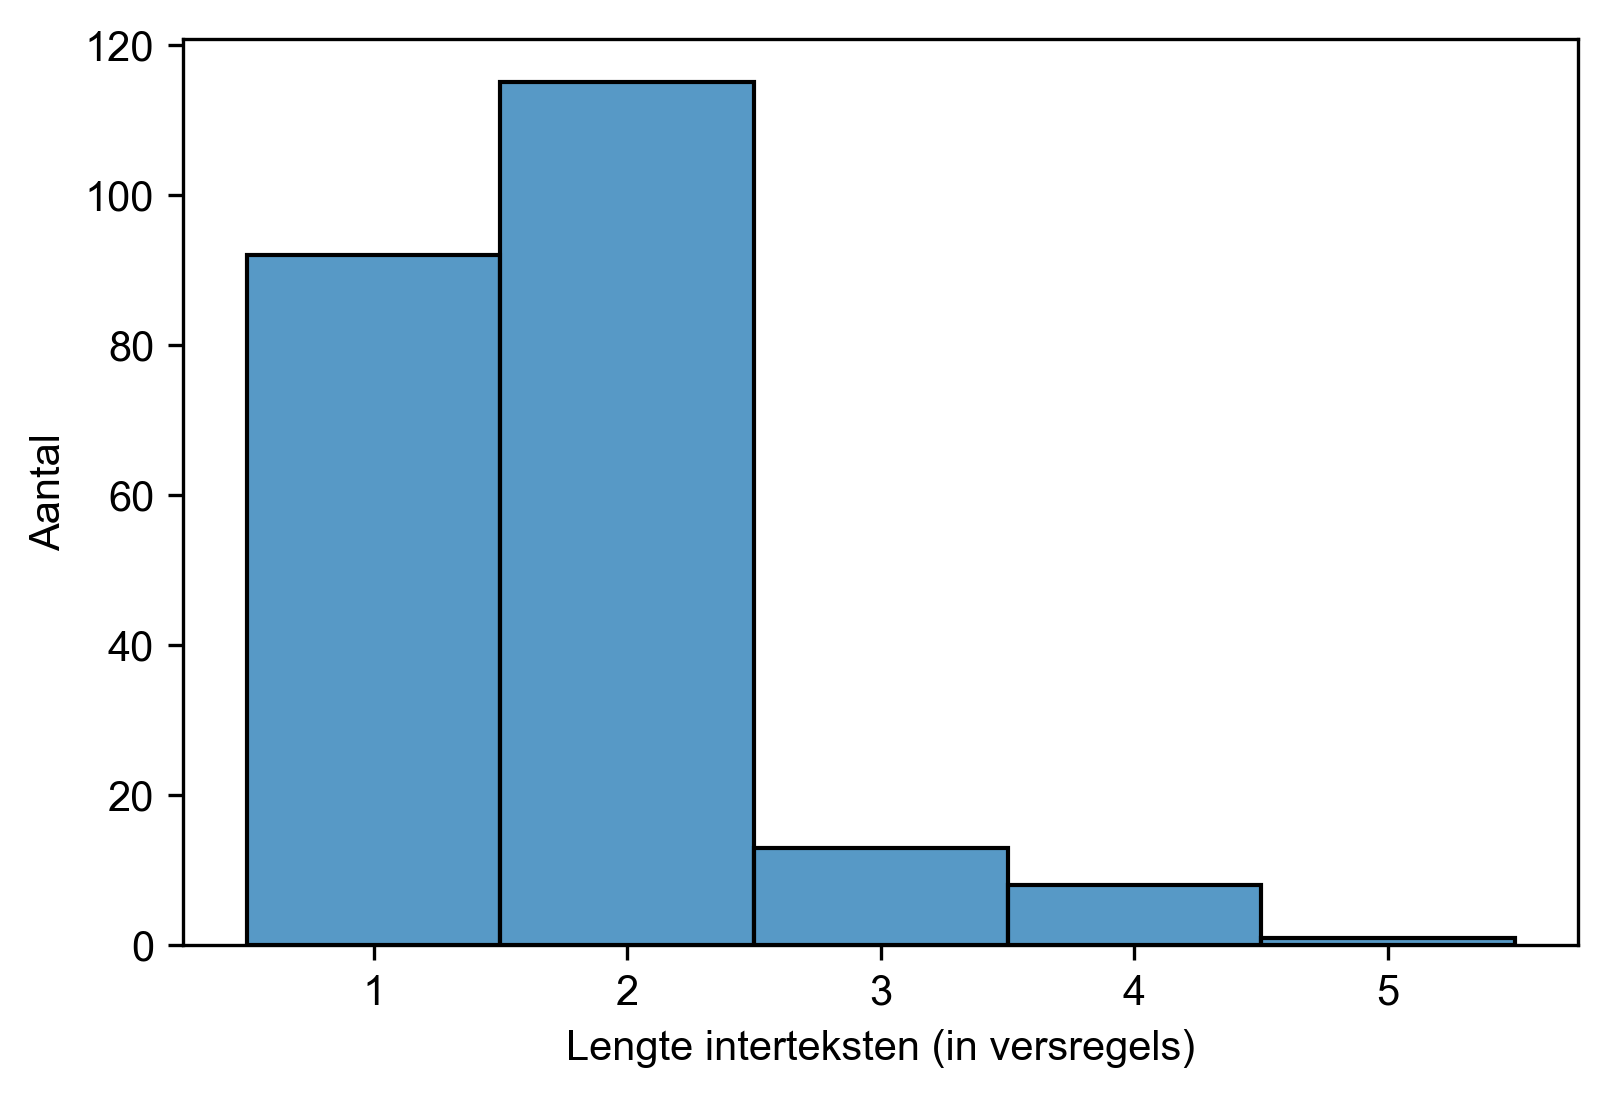

In [4]:
sb.histplot(data=intertexts, x="verse-length", discrete=True)
plt.xlabel('Lengte interteksten (in versregels)')
plt.ylabel('Aantal')
plt.savefig(f'{fig_dir}/intertext_dist.png', transparent=True);

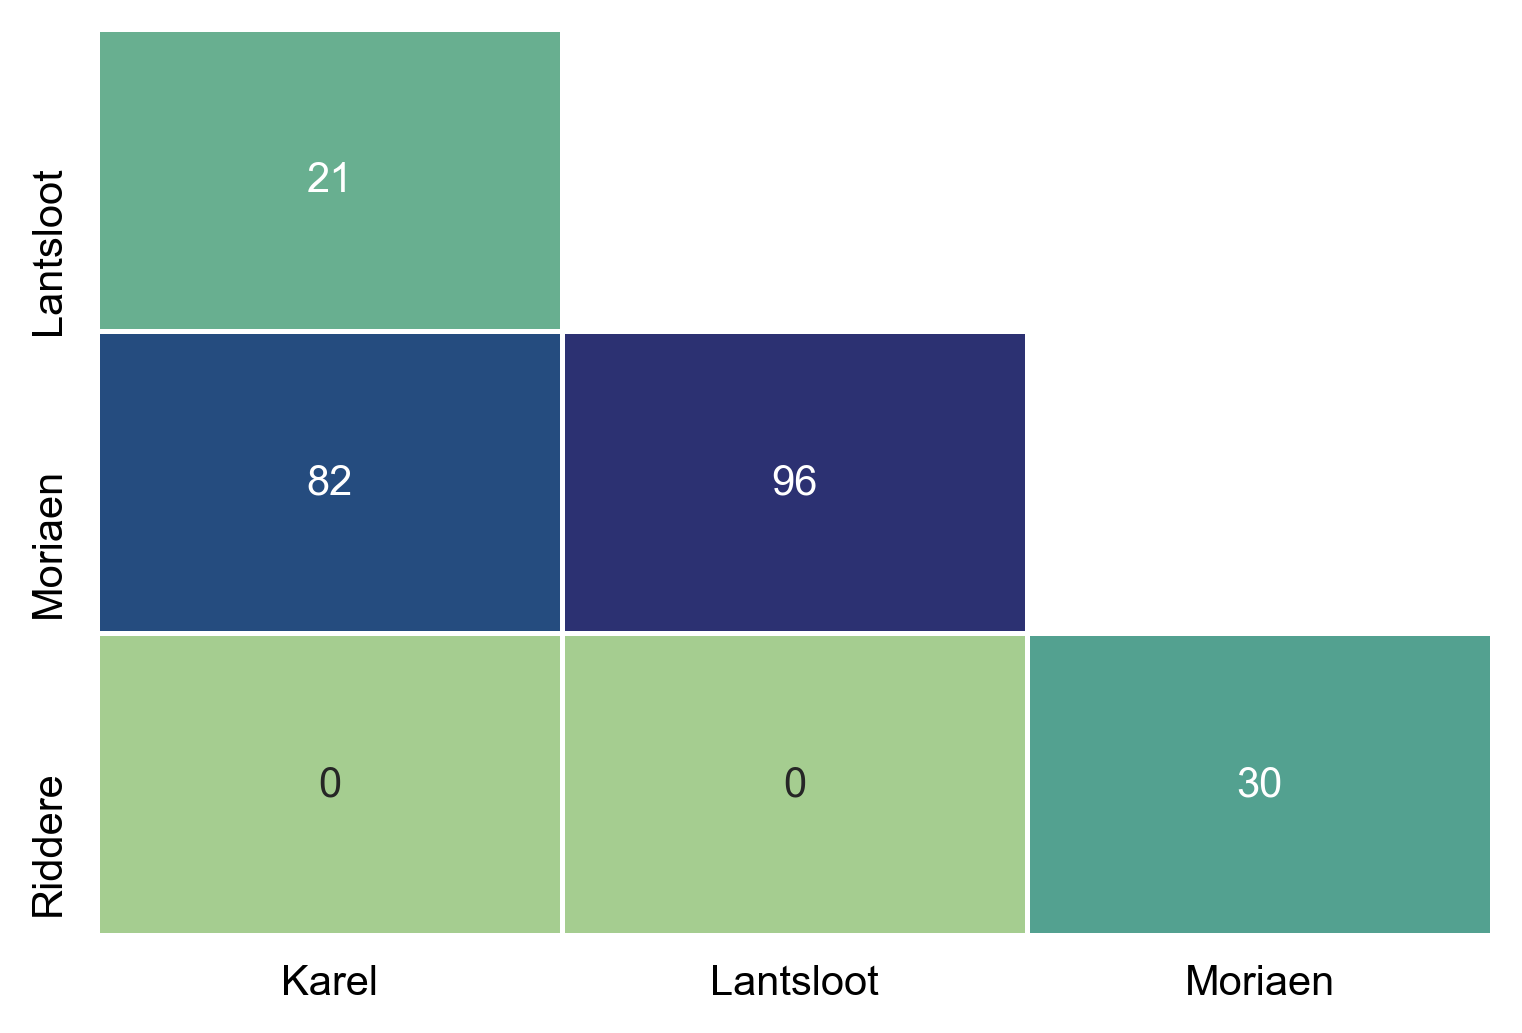

In [5]:
titles = sorted(set(intertexts['source'].tolist() + intertexts['target'].tolist()))
counts = np.zeros((len(titles), len(titles)))
for _, row in intertexts.iterrows():
    counts[titles.index(row['source']), titles.index(row['target'])] += 1
    counts[titles.index(row['target']), titles.index(row['source'])] += 1
np.fill_diagonal(counts, np.nan)
counts[np.triu_indices(4)] = np.nan
titles = [t.split()[0] for t in titles]
counts = pd.DataFrame(counts, columns=titles, index=titles)
counts = counts.iloc[1:, :-1]
ax = sb.heatmap(counts, annot=True, cmap='crest', cbar=False, linewidths=1, linecolor='white')
ax.tick_params(left=False, bottom=False)
for l in plt.gca().lines:
    l.set_alpha(0.3)
plt.savefig(f'{fig_dir}/intertext_links.png', transparent=True);

#### Load metadata

In [6]:
meta_df = pd.read_excel('../data/metadata_corrected.xlsx')
meta_df = meta_df[meta_df['exclude'] != 'x']
meta_df.sample(10)

,id,title,author,date,provenance,date_range,genre,subgenre,exclude
9,barlaam_en_josaphat_fragm_ge,Barlaam en Josaphat,NaN,1325.0,cdrom-mnl,1300-1350,Epiek,Ridder,NaN
275,roman_van_walewein,Walewein,Penninc en Pieter Vostaert,1350.0,cdrom-mnl,1350-1350,Epiek,Arthur,NaN
216,spiegel_historiael__2_fragm_l,Spiegel historiael (P2),Philip Utenbroeke,1337.5,cdrom-mnl,1325-1350,Epiek,Historiografie,NaN
120,madelgijs_fragm_be,Madelgijs,NaN,1350.0,cdrom-mnl,1340-1360,Epiek,Karel,NaN
37,collectief_lunarium_ii,Collectief lunarium II,NaN,1435.0,cdrom-mnl,1434-1436,Epiek,Didactiek,NaN
174,Rijmbijbel,Rijmbijbel,NaN,1285.0,CG1,1285-1285,Epiek,Religie,NaN
35,collectief_lunarium_iii,Collectief lunarium III,NaN,1450.0,cdrom-mnl,1440-1460,Epiek,Didactiek,NaN
255,van_den_vijf_vrouden,Van den vijf vrouden,NaN,1339.0,cdrom-mnl,1339-1339,Epiek,Didactiek,NaN
72,gedichten_hildegaersberch__hs_g,Gedichten (Willem van Hildegaersberch),Willem van Hildegaersberch,1480.0,cdrom-mnl,1470-1490,Lyriek,NaN,NaN
252,van_den_neghen_besten__lang,Van den neghen besten (lang),NaN,1465.0,cdrom-mnl,1460-1470,Epiek,Didactiek,NaN


In [7]:
def get_verse_groups(verses, size=2, intertexts=False):
    for i in range(len(verses) - (size - 1)):
        if not intertexts:
            yield ' / '.join(verses[i : i + size])
        else:
            its = Counter(verses[i : i + size])
            if None in its:
                yield None
            elif len(its) > 1:
                yield 'overlap'
            else:
                yield list(its.keys())[0]

In [8]:
def parse_xml(fn, rm_interpol=False):
    try:
        tree = lxml.etree.parse(fn)
    except OSError:
        print(f'- Could not load {fn}')
        return None
        
    if rm_interpol:
        for interpolation in tree.xpath("//interpolation"):
            interpolation.getparent().remove(interpolation)
        
    for line_node in tree.iterfind('//l'):
        try:
            intertext_id = line_node.attrib['intertext']
        except KeyError:
            intertext_id = None
        
        tokens_ = line_node.attrib['tokens'].split()
        lemmas_ = []
        
        lemma_tags = [l.text for l in line_node.iterfind('.//lemma')]
        pos_tags = [p.text for p in line_node.iterfind('.//pos')]
        
        for lemma, pos in zip(lemma_tags, pos_tags):
            for l, p in zip(lemma.split('+'), pos.split('+')):
                    if p == 'n(prop)':
                        lemmas_.append('n(prop)')
                    else:
                        lemmas_.append(l)
    
        yield tokens_, lemmas_, intertext_id

In [9]:
GROUP_SIZE = 2

titles, tokens, lemmas, intertexts = [], [], [], []

for title, group in tqdm(meta_df.groupby('title')):
    work_tokens, work_lemmas, work_intertexts = [], [], []
    
    for id_ in sorted(group['id']):
        for tok, lem, intertext_id in parse_xml(f'../data/xml/{id_}.xml'):
            work_tokens.append(tok)
            work_lemmas.append(lem)
            work_intertexts.append(intertext_id)
    
    verse_tokens = [' '.join(v) for v in work_tokens]
    verse_lemmas = [' '.join(v) for v in work_lemmas]

    verse_group_tokens = list(get_verse_groups(verse_tokens, size=GROUP_SIZE))
    verse_group_lemmas = list(get_verse_groups(verse_lemmas, size=GROUP_SIZE))
    verse_group_intertexts = list(get_verse_groups(work_intertexts, size=GROUP_SIZE, intertexts=True))

    tokens.extend(verse_group_tokens)
    lemmas.extend(verse_group_lemmas)
    intertexts.extend(verse_group_intertexts)
    titles.extend([title] * len(verse_group_lemmas))

100%|██████████| 205/205 [00:32<00:00,  6.22it/s]


In [10]:
df = pd.DataFrame(zip(titles, tokens, lemmas, intertexts), columns=('title', 'tokens', 'lemmas', 'intertext'))
df = df[df['intertext'] != 'overlap']
df[(df['title'] == 'Karel ende Elegast') & (~df['intertext'].isna())]

,title,tokens,lemmas,intertext
340350,Karel ende Elegast,Crone draghen ende houden hof / Om te meerderen sinen lof,kroon dragen en houden hof / om te meerderen zijn lof,mor-ele-2
340386,Karel ende Elegast,Als die seere was vereent / Wat ist dat dit wonder meent,als de zeer zijn verenen / wat het zijn dat dit wonder menen,lan-ele-47
340398,Karel ende Elegast,Mijn lant is so groot / Men vint nyewers sijns ghenoot,mijn land zijn zo groot / men vinden nieuwer zijn genoot,mor-ele-5
340437,Karel ende Elegast,En wil ic niet laten achter / Ic sel dief wesen al ist lachter,ne willen ik niet laten achter / ik zullen dief wezen al zijn het lachter,mor-ele-8
340465,Karel ende Elegast,Moet varen in een lant / Dat mi is vremde ende onbecant,moeten varen in een land / dat ik zijn vreemd en onbekend,mor-ele-10
340467,Karel ende Elegast,Mit deser talen ghinc hem gereyden / Die coninc karel ende cleyden,met deze taal gaan hij gereden / de koning n(prop) en kleden,mor-ele-11
340540,Karel ende Elegast,Dieue te hatene daer icse wiste / Die den lieden mit liste,dief te haten daar ik zij weten / die de lieden met list,mor-ele-15
340564,Karel ende Elegast,Beide borch ende lant / Des was ic herde onbekant,beide burg en land / dat zijn ik harden onbekend,mor-ele-16
340630,Karel ende Elegast,Nochtan weet ic te voren wel / Tis die duuel ende niemant el,nochtan weten ik te voren wel / het is de duivel en niemand el,mor-ele-17
340644,Karel ende Elegast,Pensde hi in sinen sin / Dese is verdoelt hier in,peinzen hij in zijn zin / deze zijn verdolen hier in,mor-ele-19


In [11]:
def tokenizer(text):
    return text.replace(' / ', ' ').lower().strip().split()

vec = TfidfVectorizer(max_features=10000, min_df=2,
                      tokenizer=tokenizer, token_pattern=None)
X = vec.fit_transform(df['lemmas'])
X.shape

(925352, 10000)

In [12]:
def add_rhyme_column(df):
    rhyme_words = []
    for lemmas in df['lemmas']:
        rhymes = []
        for verse in lemmas.split(' / '):
            rhymes.append(verse.strip().split()[-1])
        rhyme_words.append(' '.join(rhymes))
    df['rhyme'] = rhyme_words
    return df

In [13]:
df = add_rhyme_column(df)
df.head()
df[(df['title'] == 'Karel ende Elegast') & (~df['intertext'].isna())]

,title,tokens,lemmas,intertext,rhyme
340350,Karel ende Elegast,Crone draghen ende houden hof / Om te meerderen sinen lof,kroon dragen en houden hof / om te meerderen zijn lof,mor-ele-2,hof lof
340386,Karel ende Elegast,Als die seere was vereent / Wat ist dat dit wonder meent,als de zeer zijn verenen / wat het zijn dat dit wonder menen,lan-ele-47,verenen menen
340398,Karel ende Elegast,Mijn lant is so groot / Men vint nyewers sijns ghenoot,mijn land zijn zo groot / men vinden nieuwer zijn genoot,mor-ele-5,groot genoot
340437,Karel ende Elegast,En wil ic niet laten achter / Ic sel dief wesen al ist lachter,ne willen ik niet laten achter / ik zullen dief wezen al zijn het lachter,mor-ele-8,achter lachter
340465,Karel ende Elegast,Moet varen in een lant / Dat mi is vremde ende onbecant,moeten varen in een land / dat ik zijn vreemd en onbekend,mor-ele-10,land onbekend
340467,Karel ende Elegast,Mit deser talen ghinc hem gereyden / Die coninc karel ende cleyden,met deze taal gaan hij gereden / de koning n(prop) en kleden,mor-ele-11,gereden kleden
340540,Karel ende Elegast,Dieue te hatene daer icse wiste / Die den lieden mit liste,dief te haten daar ik zij weten / die de lieden met list,mor-ele-15,weten list
340564,Karel ende Elegast,Beide borch ende lant / Des was ic herde onbekant,beide burg en land / dat zijn ik harden onbekend,mor-ele-16,land onbekend
340630,Karel ende Elegast,Nochtan weet ic te voren wel / Tis die duuel ende niemant el,nochtan weten ik te voren wel / het is de duivel en niemand el,mor-ele-17,wel el
340644,Karel ende Elegast,Pensde hi in sinen sin / Dese is verdoelt hier in,peinzen hij in zijn zin / deze zijn verdolen hier in,mor-ele-19,zin in


## Nearest neighbors

In [14]:
def nearest_verses(title1, title2, base_df, vectorizer, prop_filt=2, rhyme_weight=.15):
    A = base_df[base_df['title'] == title1]
    B = base_df[base_df['title'] == title2]
    
    AX = vec.transform(A['lemmas']) + rhyme_weight * vec.transform(A['rhyme'])
    BX = vec.transform(B['lemmas']) + rhyme_weight * vec.transform(B['rhyme'])
    
    nearest = []
    for i, ax in enumerate(AX):
        distances = pairwise_distances(ax, BX, metric='cosine').flatten()
        top_i = distances.argsort()[0]
        nearest.append((A.iloc[i]['tokens'], B.iloc[top_i]['tokens'],
                        A.iloc[i]['lemmas'], B.iloc[top_i]['lemmas'],
                        A.iloc[i]['title'], B.iloc[top_i]['title'],
                        A.iloc[i]['intertext'], B.iloc[top_i]['intertext'],
                        distances[top_i]))

    nearest = pd.DataFrame(nearest,
                           columns=['tokens1', 'tokens2', 'lemmas1', 'lemmas2',
                                    'title1', 'title2', 'intertext1', 'intertext2',
                                    'distance'])

    nearest = nearest[nearest['title1'] != nearest['title2']]
    nearest = nearest[
                      (nearest['lemmas1'].str.count('n\(prop\)') < prop_filt) & \
                      (nearest['lemmas1'].str.count('n\(prop\)') < prop_filt) 
                     ]
    return nearest

In [15]:
nearest_df = nearest_verses('Moriaen', 'Lantsloot van der Haghedochte',
#nearest_df = nearest_verses('Limborch', 'Roman der Lorreinen',
#nearest_df = nearest_verses('Rijmkroniek van Woeringen', 'Grimbergse oorlog',
#nearest_df = nearest_verses('Parthonopeus van Bloys', 'Floris ende Blancefloer',
                            base_df=df, vectorizer=vec, prop_filt=2)
nearest_df = nearest_df.sort_values(by='distance')
nearest_df.head(50).to_excel('../figures/mor-ele-selection.xlsx')
nearest_df.head(50)

,tokens1,tokens2,lemmas1,lemmas2,title1,title2,intertext1,intertext2,distance
1699,Des men drinken mochte ende eten / Ende alles leets daer bi vergeten,Dat men drinken mocht ende eten / Ende leets bi vergheten,dat men drinken mogen en eten / en al leed daar bij vergeten,dat men drinken mogen en eten / en leed bij vergeten,Moriaen,Lantsloot van der Haghedochte,lan-ele-62,lan-ele-62,0.028856
886,Die es der werelt toeverlaet / Die late mi noch mine mesdaet,Die es der warelt toeuerlaet / Die late mj mine mesdaet,die zijn de wereld toeverlaat / die laten ik nog mijn misdaad,die zijn de wereld toeverlaat / die laten ik mijn misdaad,Moriaen,Lantsloot van der Haghedochte,lan-ele-52,lan-ele-52,0.046525
1795,Ende drogen des over een / Die daer waren in den steen,Si hebben gedreghen ouer een / Die daer sijn in den steen,en dragen de over een / die daar zijn in de steen,zij hebben dragen over een / die daar zijn in de steen,Moriaen,Lantsloot van der Haghedochte,mor-ele-40,mor-ele-40,0.061468
859,Alse lange alsi mochte leven / Getrouwelike sonder begeven,Also langhe alsic sal leuen / Ghetrouwelike sonder begheuen,alzo lang als zij mogen leven / getrouwelijk zonder begeven,alzo lang als ik zullen leven / getrouwelijk zonder begeven,Moriaen,Lantsloot van der Haghedochte,None,None,0.068831
1147,Maer dat was pine jegen spoet / Al haddemen hem gegeven alt goet,Mar dat was pine ieghen spoet / Die hare ghegheuen hadde alt goet,maar dat zijn pijn jegen spoed / al hebben men hij geven al dat goed,maar dat zijn pijn jegen spoed / die zij geven hebben al dat goed,Moriaen,Lantsloot van der Haghedochte,mor-ele-49,mor-ele-49,0.070079
2328,Tes icker weder come toe / Ende ic sal u vort secgen hoe,Des icker weder come toe / Ende sal v segghen hoe,dat ik er weder komen te / en ik zullen gij voort zeggen hoe,dat ik er weder komen te / en zullen gij zeggen hoe,Moriaen,Lantsloot van der Haghedochte,None,None,0.087827
323,Nu ne licgic nembermee / Boven enen nacht of twee,Dat hine laghe nemmermee / Bouen ere nacht ofte twee,nu ne ik liggen nimmermee / boven een nacht of twee,dat hij hij liggen nimmermee / boven een nacht of twee,Moriaen,Lantsloot van der Haghedochte,lan-ele-38,lan-ele-38,0.094798
957,Ende vrachden hem om niemare / Ofter enech ridder leden ware,Ende si vragheden hem om niemare / Of daer enich ridder leden ware,en vragen hij om nieuwmaar / af enig ridder lijden zijn,en zij vragen hij om nieuwmaar / of daar enig ridder lijden zijn,Moriaen,Lantsloot van der Haghedochte,None,lan-ele-36,0.104913
1609,Ende alse Walewein hadde verwonnen / Ende hem God hadde geonnen,Doe lantsloot hadde verwonnen / Des hem god hadde gheonnen,en als n(prop) hebben verwinnen / en hij god hebben gene,toen n(prop) hebben verwinnen / dat hij god hebben gene,Moriaen,Lantsloot van der Haghedochte,None,None,0.112968
1966,Der doet hi hadde daer menegen vrient / Die sere clageden haren toren,Hi hadde nochtan meneghen vrient / Die sere clagheden haren toren,de dood hij hebben daar menig vriend / die zeer klagen haar toorn,hij hebben nochtan menig vriend / die zeer klagen haar toorn,Moriaen,Lantsloot van der Haghedochte,lan-ele-56,lan-ele-56,0.117554


#### Intermezzo: voorbeeld TF-IDF

In [16]:
small = df[df['title'] == 'Karel ende Elegast'].iloc[[20]]
small

,title,tokens,lemmas,intertext,rhyme
340358,Karel ende Elegast,Wapent v ende vaert stelen / God die hiet mi v beuelen,wapenen gij en varen stelen / n(prop) die heten ik gij bevelen,None,stelen bevelen


In [17]:
vec = TfidfVectorizer(max_features=5000, min_df=2,
                      tokenizer=tokenizer, norm='l1',
                      token_pattern=None, use_idf=False).fit(df['lemmas'])

In [18]:
small_vocab = set(' '.join(small['lemmas']).split())
print(small_vocab)
vocab = vec.get_feature_names()
small_vocab = sorted({v for v in small_vocab if v in vocab})
print(small_vocab)

{'wapenen', 'die', 'stelen', '/', 'ik', 'bevelen', 'varen', 'en', 'heten', 'n(prop)', 'gij'}
['bevelen', 'die', 'en', 'gij', 'heten', 'ik', 'n(prop)', 'stelen', 'varen', 'wapenen']


In [19]:
small_x = vec.transform(small['lemmas']).toarray()
features = vec.get_feature_names()
idxs = [features.index(l) for l in small_vocab]
rel_freq = pd.DataFrame(small_x[:, idxs], columns=small_vocab, index=['Rel. freq.'])
rel_freq

,bevelen,die,en,gij,heten,ik,n(prop),stelen,varen,wapenen
Rel. freq.,0.090909,0.090909,0.090909,0.181818,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909


In [20]:
vec = TfidfVectorizer(max_features=5000, min_df=2,
                      token_pattern=None,
                      tokenizer=tokenizer, use_idf=True).fit(df['lemmas'])
small_x = vec.transform(small['lemmas']).toarray()
features = vec.get_feature_names()
idxs = [features.index(l) for l in small_vocab]
tfidf = pd.DataFrame(small_x[:, idxs], columns=small_vocab, index=['TF-IDF'])
tfidf

,bevelen,die,en,gij,heten,ik,n(prop),stelen,varen,wapenen
TF-IDF,0.401369,0.160796,0.114561,0.39244,0.300772,0.168263,0.134101,0.469276,0.303691,0.443516


In [21]:
small_x = vec.transform(small['rhyme']).toarray()
rhyme = pd.DataFrame(small_x[:, idxs], columns=small_vocab, index=['Only rhyme'])
rhyme

,bevelen,die,en,gij,heten,ik,n(prop),stelen,varen,wapenen
Only rhyme,0.649981,0.0,0.0,0.0,0.0,0.0,0.0,0.759951,0.0,0.0


In [22]:
small_x = vec.transform(small['lemmas']).toarray() + .15 * vec.transform(small['rhyme']).toarray()
rhyme_weight = pd.DataFrame(small_x[:, idxs], columns=small_vocab, index=['Rhyme weight (.15)'])
rhyme_weight

,bevelen,die,en,gij,heten,ik,n(prop),stelen,varen,wapenen
Rhyme weight (.15),0.498866,0.160796,0.114561,0.39244,0.300772,0.168263,0.134101,0.583269,0.303691,0.443516


In [23]:
table = pd.concat((rel_freq, tfidf, rhyme, rhyme_weight))
table

,bevelen,die,en,gij,heten,ik,n(prop),stelen,varen,wapenen
Rel. freq.,0.090909,0.090909,0.090909,0.181818,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909
TF-IDF,0.401369,0.160796,0.114561,0.392440,0.300772,0.168263,0.134101,0.469276,0.303691,0.443516
Only rhyme,0.649981,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.759951,0.000000,0.000000
Rhyme weight (.15),0.498866,0.160796,0.114561,0.392440,0.300772,0.168263,0.134101,0.583269,0.303691,0.443516


#### Comparison of verses

In [24]:
targets = df.loc[[465393, 516416, 386910, 341364]]
targets

,title,tokens,lemmas,intertext,rhyme
465393,Moriaen,Maer dat was pine jegen spoet / Al haddemen hem gegeven alt goet,maar dat zijn pijn jegen spoed / al hebben men hij geven al dat goed,mor-ele-49,spoed goed
516416,Riddere metter mouwen,Maer dat was pine jegen spoet / Die porte hen nieman daer ontoet,maar dat zijn pijn jegen spoed / de poort zij niemand daar onttoen,None,spoed onttoen
386910,Lantsloot van der Haghedochte,Mar dat was pine ieghen spoet / Die hare ghegheuen hadde alt goet,maar dat zijn pijn jegen spoed / die zij geven hebben al dat goed,mor-ele-49,spoed goed
341364,Karel ende Elegast,Noch bi nachte noch bi daghe / Dats pine teghen spoet,nog bij nacht noch bij dag / dat zijn pijn tegen spoed,None,dag spoed


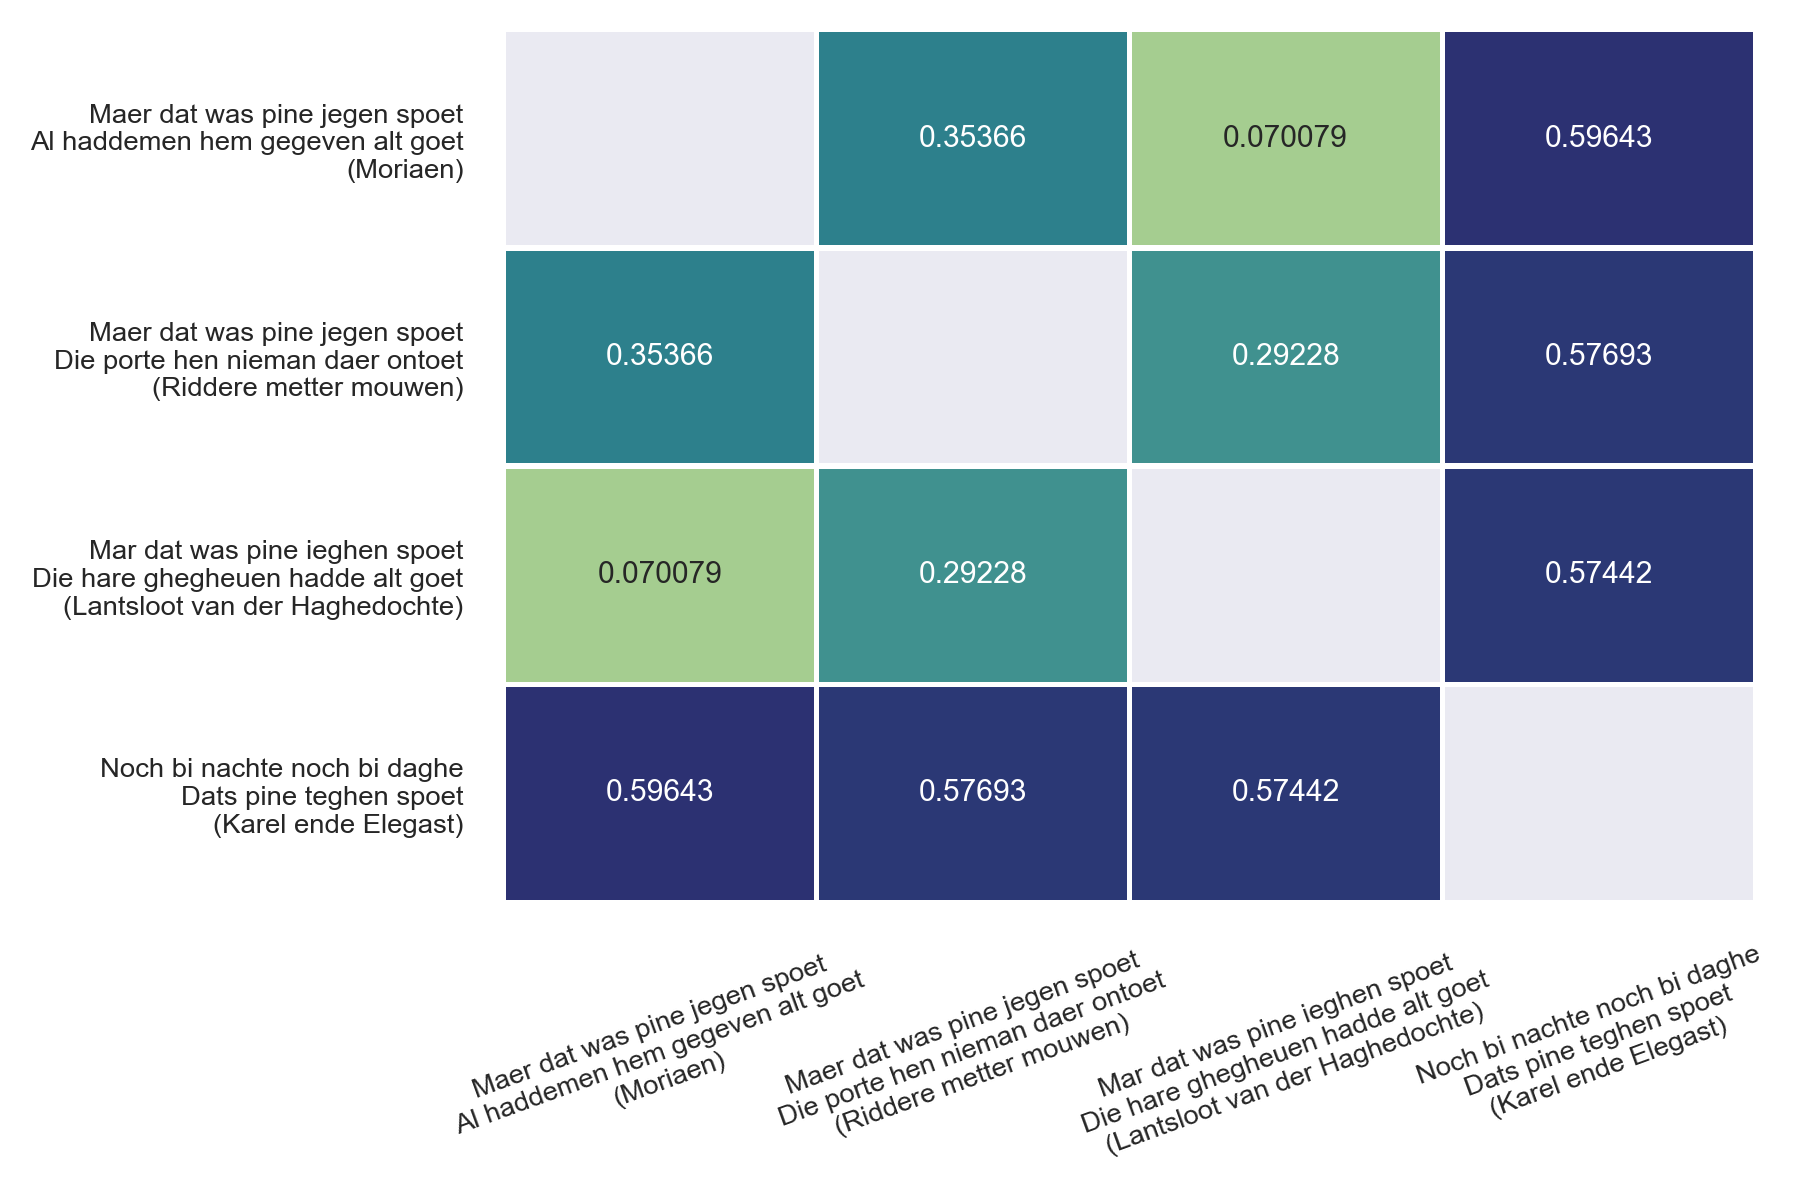

In [25]:
small_x = vec.transform(targets['lemmas']).toarray() + .15 * vec.transform(targets['rhyme']).toarray()
distances = squareform(pdist(small_x, metric='cosine'))
np.fill_diagonal(distances, np.nan)
labels = targets['tokens']
labels = [l.replace(' / ', '\n') for l in labels]
labels = [f'{label}\n({title})' for label, title in zip(labels, targets['title'])]
distances = pd.DataFrame(distances, index=labels, columns=labels)
sb.set(font_scale=.6)
ax = sb.heatmap(distances, annot=True, cmap='crest', cbar=False,
                linewidths=1, linecolor='white', fmt='.5g')
ax.tick_params(left=False, bottom=False)
for l in plt.gca().lines:
    l.set_alpha(0.3)
plt.xticks(rotation=20)
plt.tight_layout()
plt.savefig(f'{fig_dir}/example_cosine.png', transparent=True);

## Precision-recall paradigm

In [26]:
meta = pd.read_excel('../data/intertexts.xlsx')
meta.sample(5)

,ID,source,src-passage,target,trg-passage,verse-length,biblio,remarks
127,mor-ele-74,Lantsloot van der Haghedochte,Dat hi noch bedorue Ende van sinen wonden storue:,Moriaen,Dat en mochte niet bederuen Noch van genen wonden steruen.,2,"Heeroma 1973b, Moriaen (II)",NaN
88,mor-mou-7,Moriaen,Soe waent u bat beraden.,Riddere metter mouwen,Ic sal u bat beraden,1,Van der Stempel 1921,NaN
85,mor-mou-4,Moriaen,Doe hi achterst van hare sciet,Riddere metter mouwen,Doe hi achters van hem sciet,1,Van der Stempel 1918,Double case
99,mor-mou-18,Moriaen,Hi sloecht ontwee asst ware .I. riet.,Riddere metter mouwen,Ontwee oft ware een vilt.,1,Van der Stempel 1932,NaN
109,mor-mou-28,Moriaen,Alse die bataelge was gedaen / Si hadden voles vele gevaen / Ende den coninc van Yrlant: / Het was hen wel gegaen in hant.,Riddere metter mouwen,Dattie coninc van Yrlant / Selve moeste gaen in hant / Ende liet hem den riddere vaen: / Doe was dat striden scire gedaen.,4,Van der Stempel 1942,NaN


Determine rhyme weight with no restrictions on vocabulary size, except for `min_df=2`:

In [27]:
vec = TfidfVectorizer(max_features=None, min_df=2,
                      tokenizer=tokenizer, token_pattern=None).fit(df['lemmas'])

In [29]:
def precision_recall(df, meta, vec, rhyme_weight=.15):
    titles = set(list(meta['source']) + list(meta['target']))
    relevances, distances = [], []

    for t1, t2 in product(titles, titles):
        if t1 == t2:
            continue

        m = meta[meta['verse-length'] >= 2]
        m = m[(m['source'] == t1) | (m['source'] == t2)]
        m = m[(m['target'] == t1) | (m['target'] == t2)]

        if not len(m):
            continue

        A = df[(~df['intertext'].isna()) & (df['title'] == t1)]
        B = df[df['title'] == t2]

        AX = vec.transform(A['lemmas']) + rhyme_weight * vec.transform(A['rhyme'])
        BX = vec.transform(B['lemmas']) + rhyme_weight * vec.transform(B['rhyme'])

        all_distances = pairwise_distances(AX, BX, metric='cosine')

        for a_idx, (_, a) in enumerate(A.iterrows()):
            distances.extend(all_distances[a_idx])
            relevances.extend((B['intertext'] == a['intertext']).astype(int))
    
    return relevances, distances

In [29]:
relevances, distances = precision_recall(df, meta, vec, rhyme_weight=0)

Use complement of the cosine distance as a pseudo-probability:

In [30]:
distances = 1 - np.array(distances)

max(f1)=0.3525 @ theta=0.5001


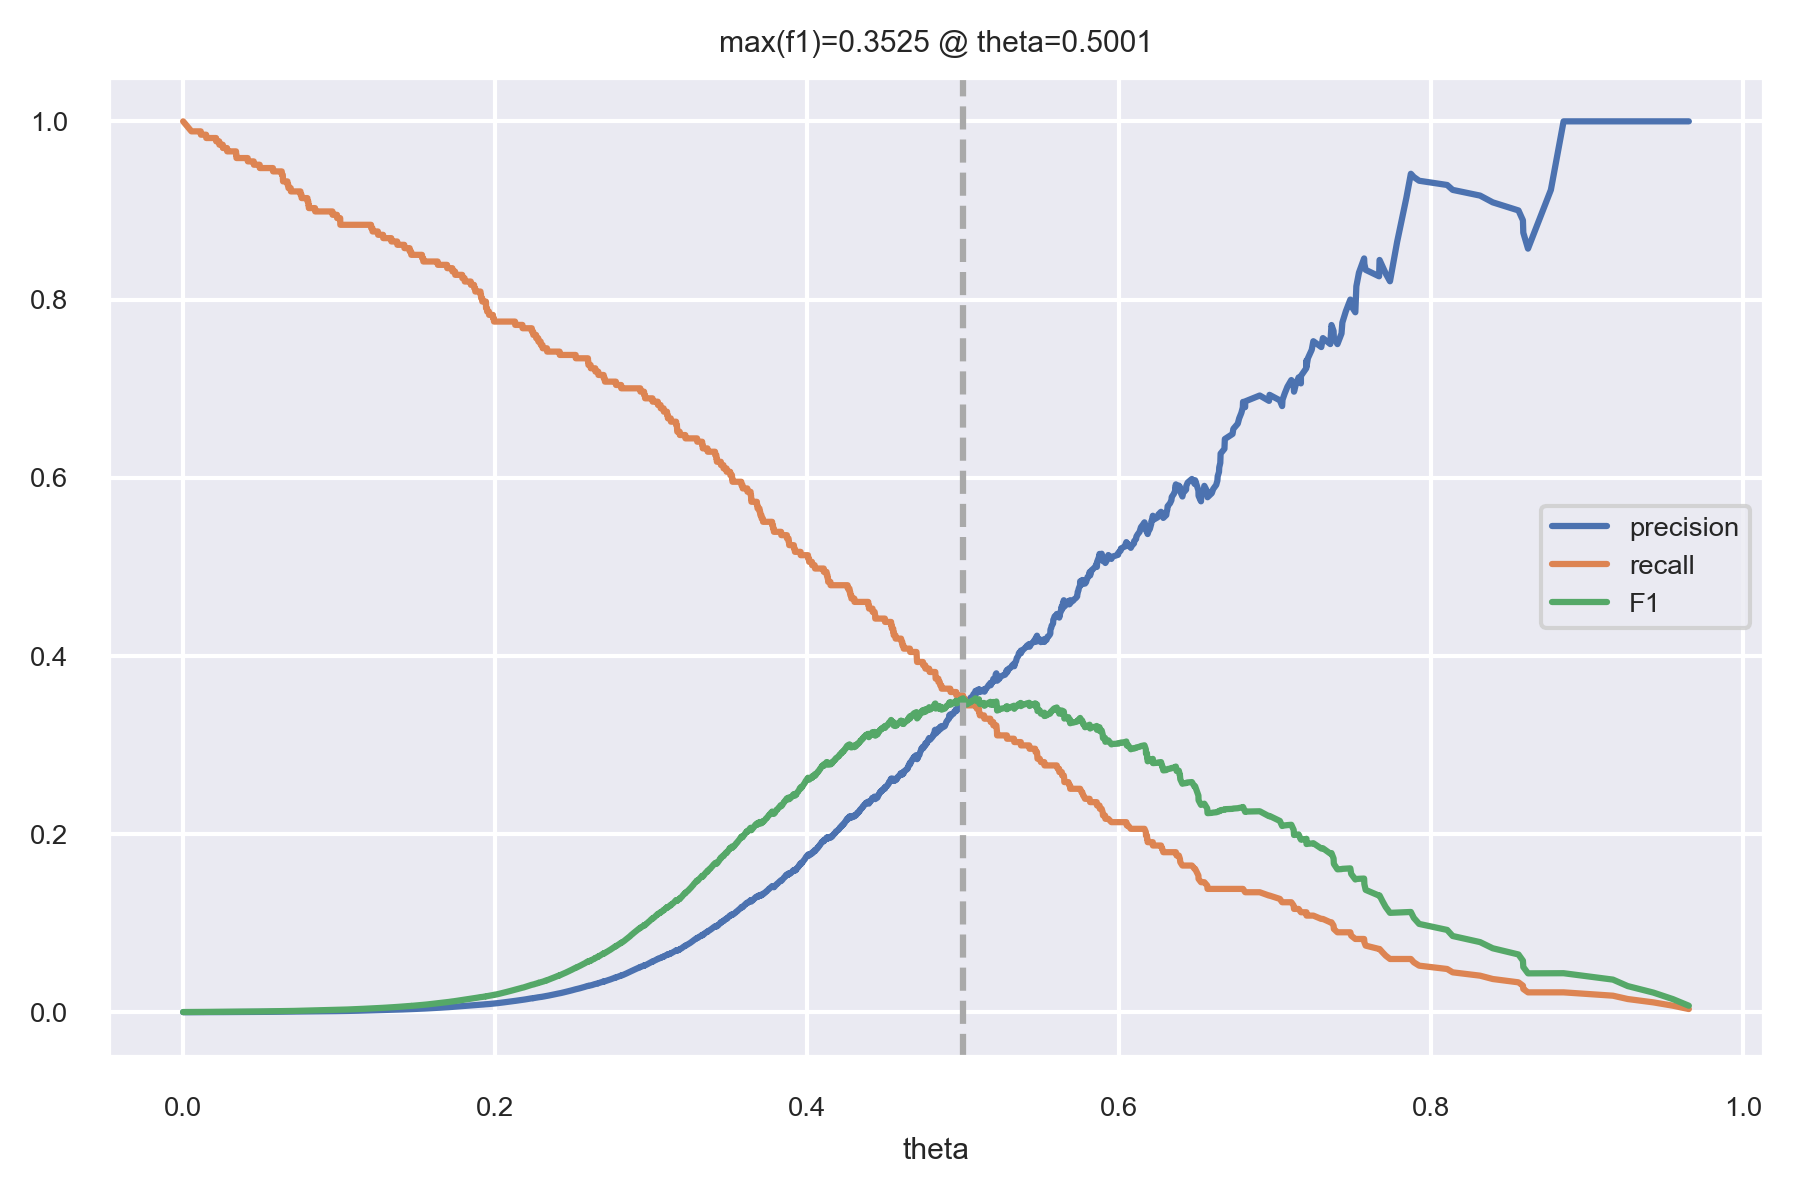

In [31]:
precisions, recalls, thresholds = precision_recall_curve(relevances, distances)
f1s = (2 * precisions * recalls) / (precisions + recalls)

max_f1_idx = np.array(f1s).argmax()
max_f1 = f1s[max_f1_idx]
max_f1_th = thresholds[max_f1_idx]
print(f'max(f1)={round(max_f1, 4)} @ theta={round(max_f1_th, 4)}')

plt.plot(thresholds, precisions[:-1], label='precision')
plt.plot(thresholds, recalls[:-1], label='recall')
plt.plot(thresholds, f1s[:-1], label='F1')
plt.axvline(max_f1_th, ls='--', c='darkgrey')
plt.gca().set_xlabel('theta')
plt.gca().legend()
plt.title(f'max(f1)={round(max_f1, 4)} @ theta={round(max_f1_th, 4)}')
plt.tight_layout();

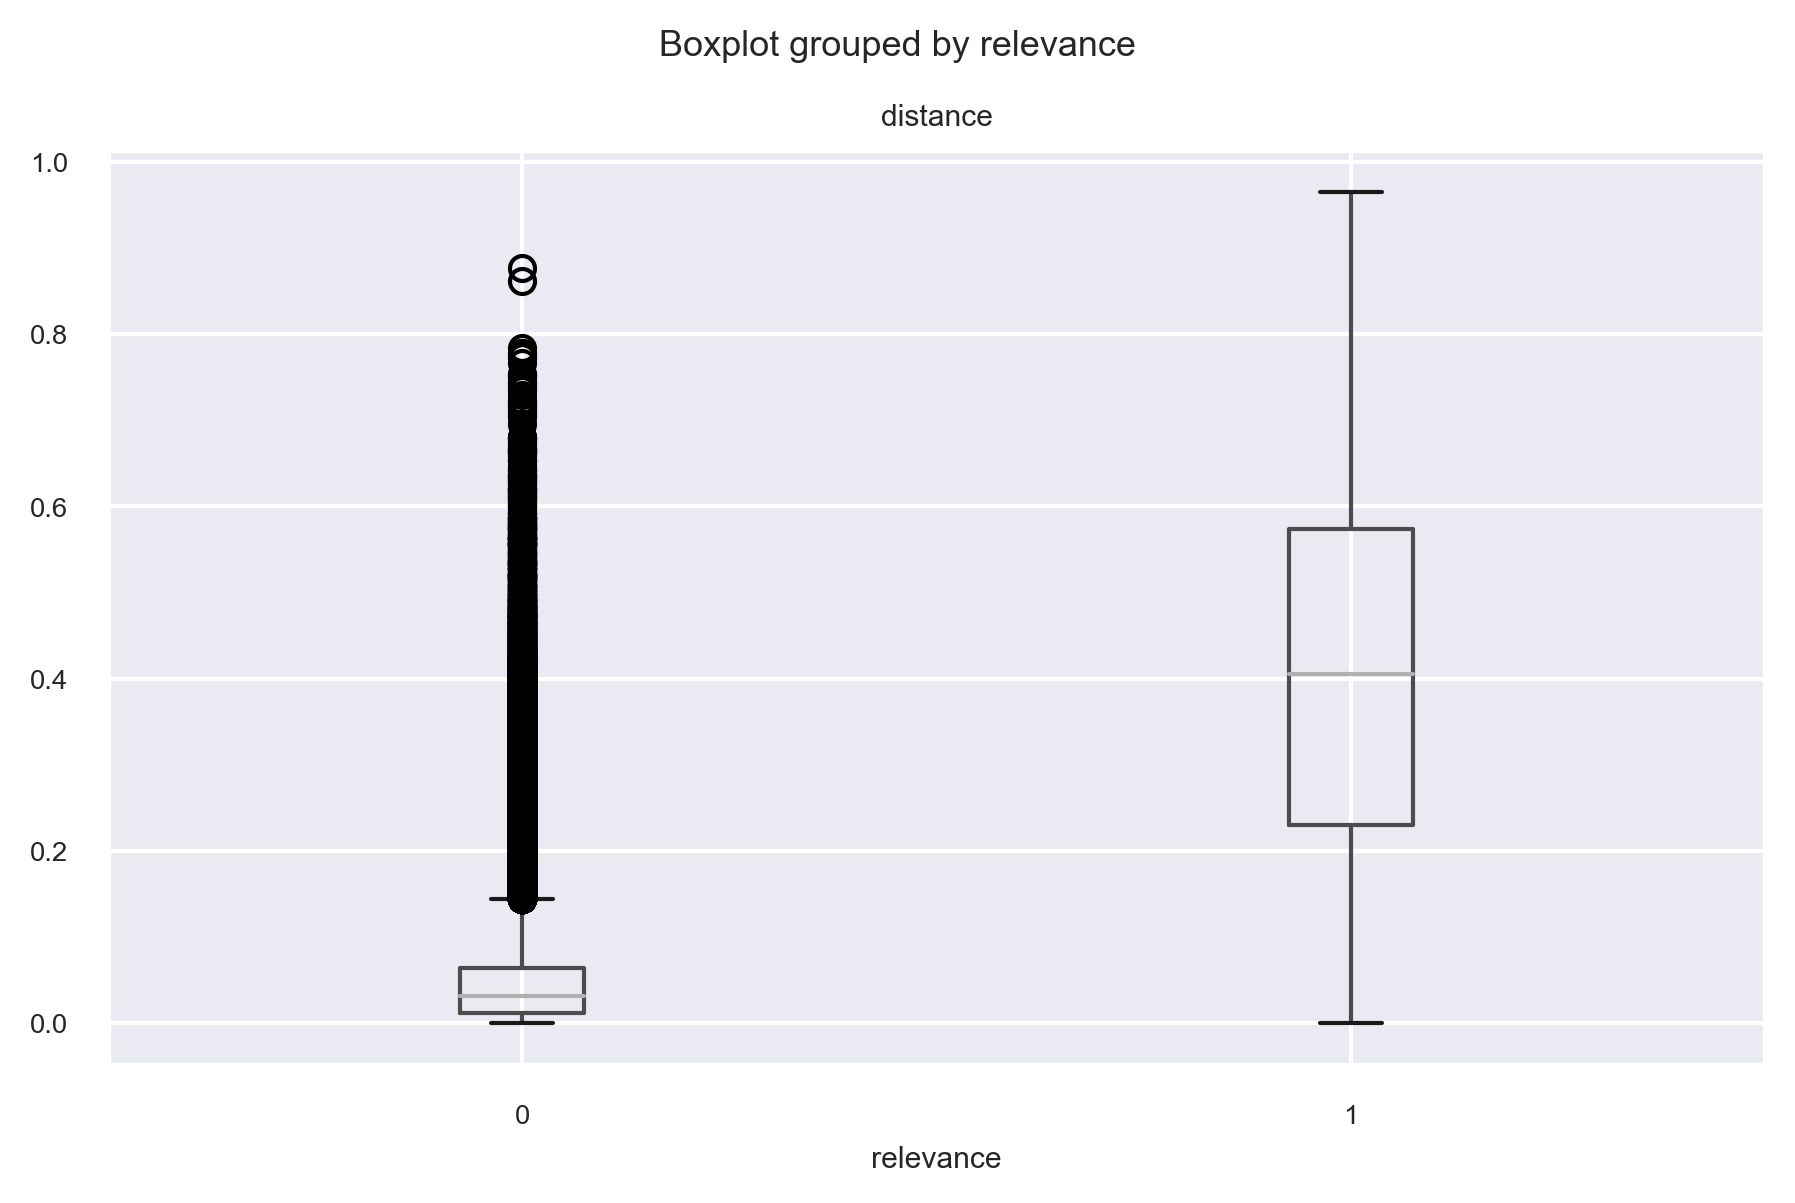

In [32]:
res_df = pd.DataFrame(zip(distances, relevances), columns=('distance', 'relevance'))
res_df.boxplot('distance', 'relevance')
plt.tight_layout();

#### Calibrate parameters

Like rhyme weight:

In [33]:
scores = []
# also negative weight for demonstration purposes:
rhyme_weights = tuple(np.linspace(-.3, 2.0, 50))

for rhyme_weight in tqdm(rhyme_weights):
    relevances, distances = precision_recall(df, meta, vec, rhyme_weight=rhyme_weight)
    distances = 1 - np.array(distances)
    auc = roc_auc_score(relevances, distances)
    av_prec = average_precision_score(relevances, distances)
    scores.append((rhyme_weight, auc, av_prec))

100%|██████████| 50/50 [04:01<00:00,  4.83s/it]


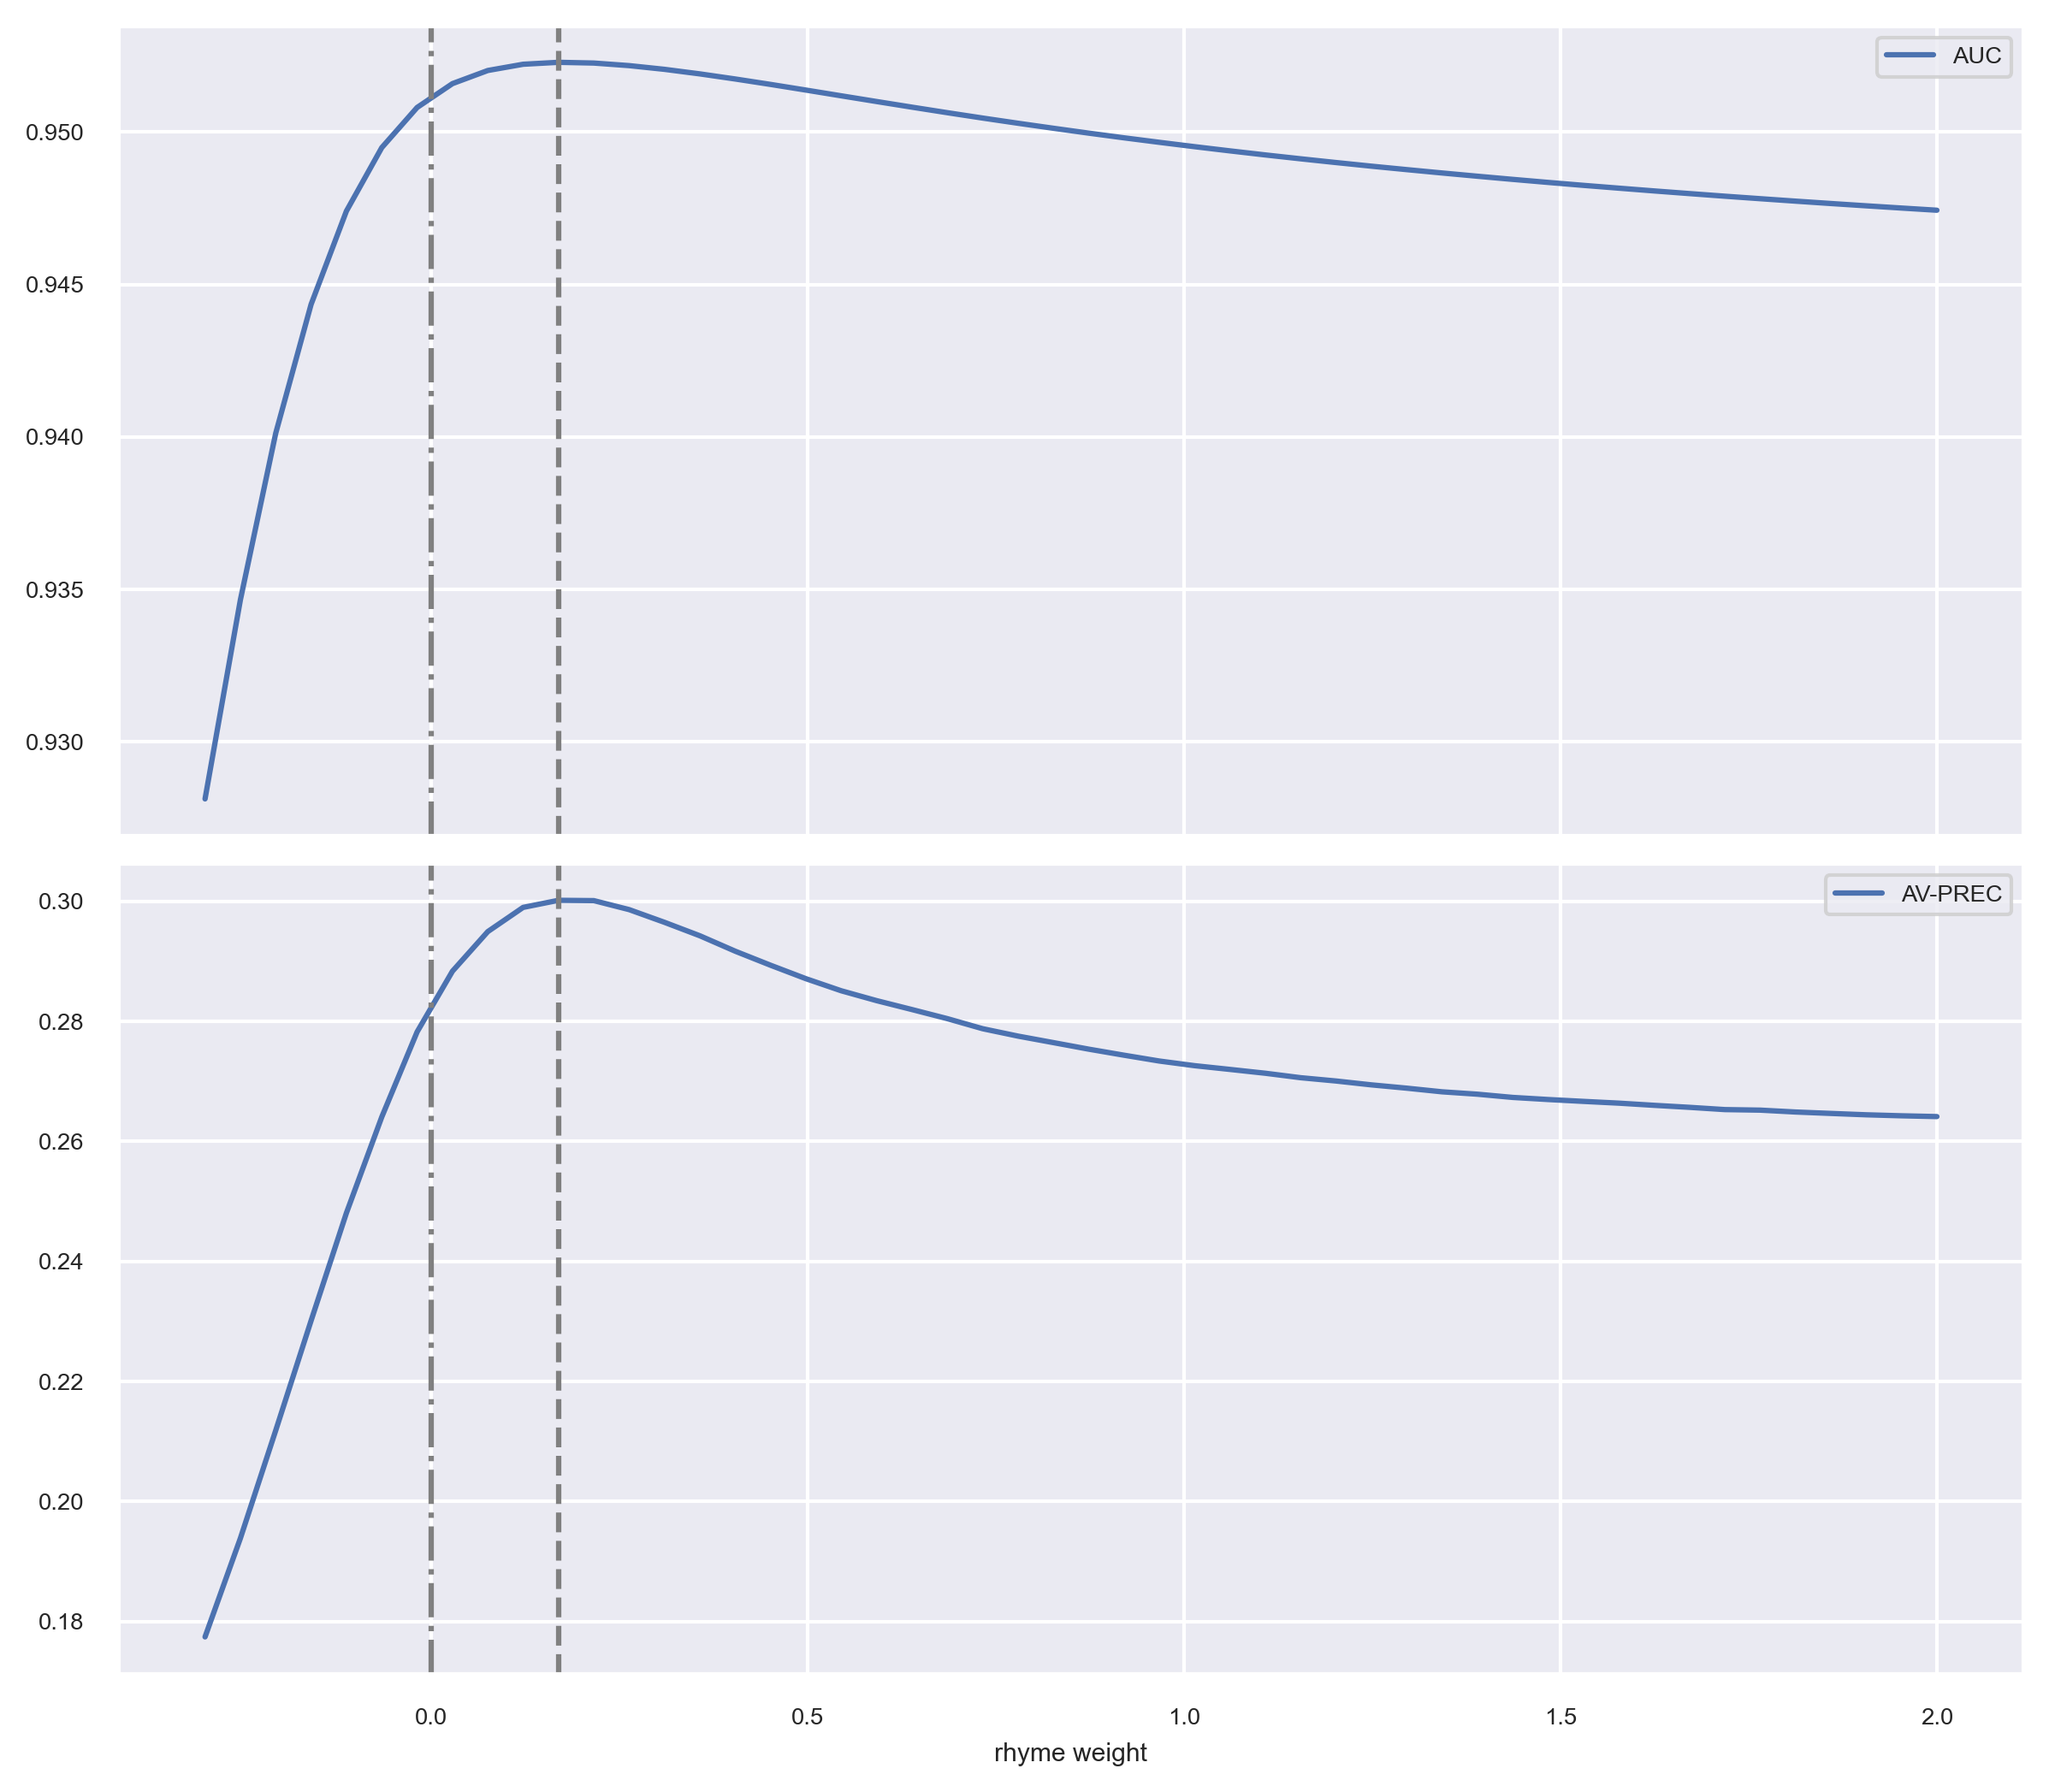

In [34]:
scores = pd.DataFrame(scores, columns=('rhyme weight', 'AUC', 'AV-PREC'))
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 7))
scores.plot('rhyme weight', 'AUC', ax=ax1)
ax1.axvline(0, ls='-.', c='grey')
ax1.axvline(scores.iloc[scores['AUC'].idxmax()]['rhyme weight'], ls='--', c='grey')
scores.plot('rhyme weight', 'AV-PREC', ax=ax2)
ax2.axvline(0, ls='-.', c='grey')
ax2.axvline(scores.iloc[scores['AV-PREC'].idxmax()]['rhyme weight'], ls='--', c='grey')
plt.tight_layout()
plt.savefig(f'{fig_dir}/rhyme_weight.png', transparent=True);

In [35]:
optim_rw = scores.iloc[scores['AUC'].idxmax()]['rhyme weight']
optim_rw

0.1693877551020408

Vocabulary size?

In [36]:
vec = TfidfVectorizer(tokenizer=tokenizer, token_pattern=None,
                      min_df=2, max_features=None).fit(df['lemmas'])
print(len(vec.get_feature_names()))

40622


Vocabulary size for TF and TF-IDF:

In [37]:
scores = []

vocab_sizes = list(range(500, 41000, 500))
parametrizations = {
                    'TF-IDF': {'min_df': 2},
                    'TF': {'use_idf': False, 'min_df': 2},
                    }

for vocab_size in tqdm(vocab_sizes):
    for param_name, param in parametrizations.items():
        param['max_features'] = vocab_size
        vec = TfidfVectorizer(tokenizer=tokenizer, token_pattern=None, **param)
        vec.fit(df['lemmas'])
        relevances, distances = precision_recall(df, meta, vec, rhyme_weight=optim_rw)
        distances = 1 - np.array(distances)
        auc = roc_auc_score(relevances, distances)
        av_prec = average_precision_score(relevances, distances)
        scores.append((param_name, vocab_size, auc, av_prec))

100%|██████████| 81/81 [29:27<00:00, 21.82s/it]


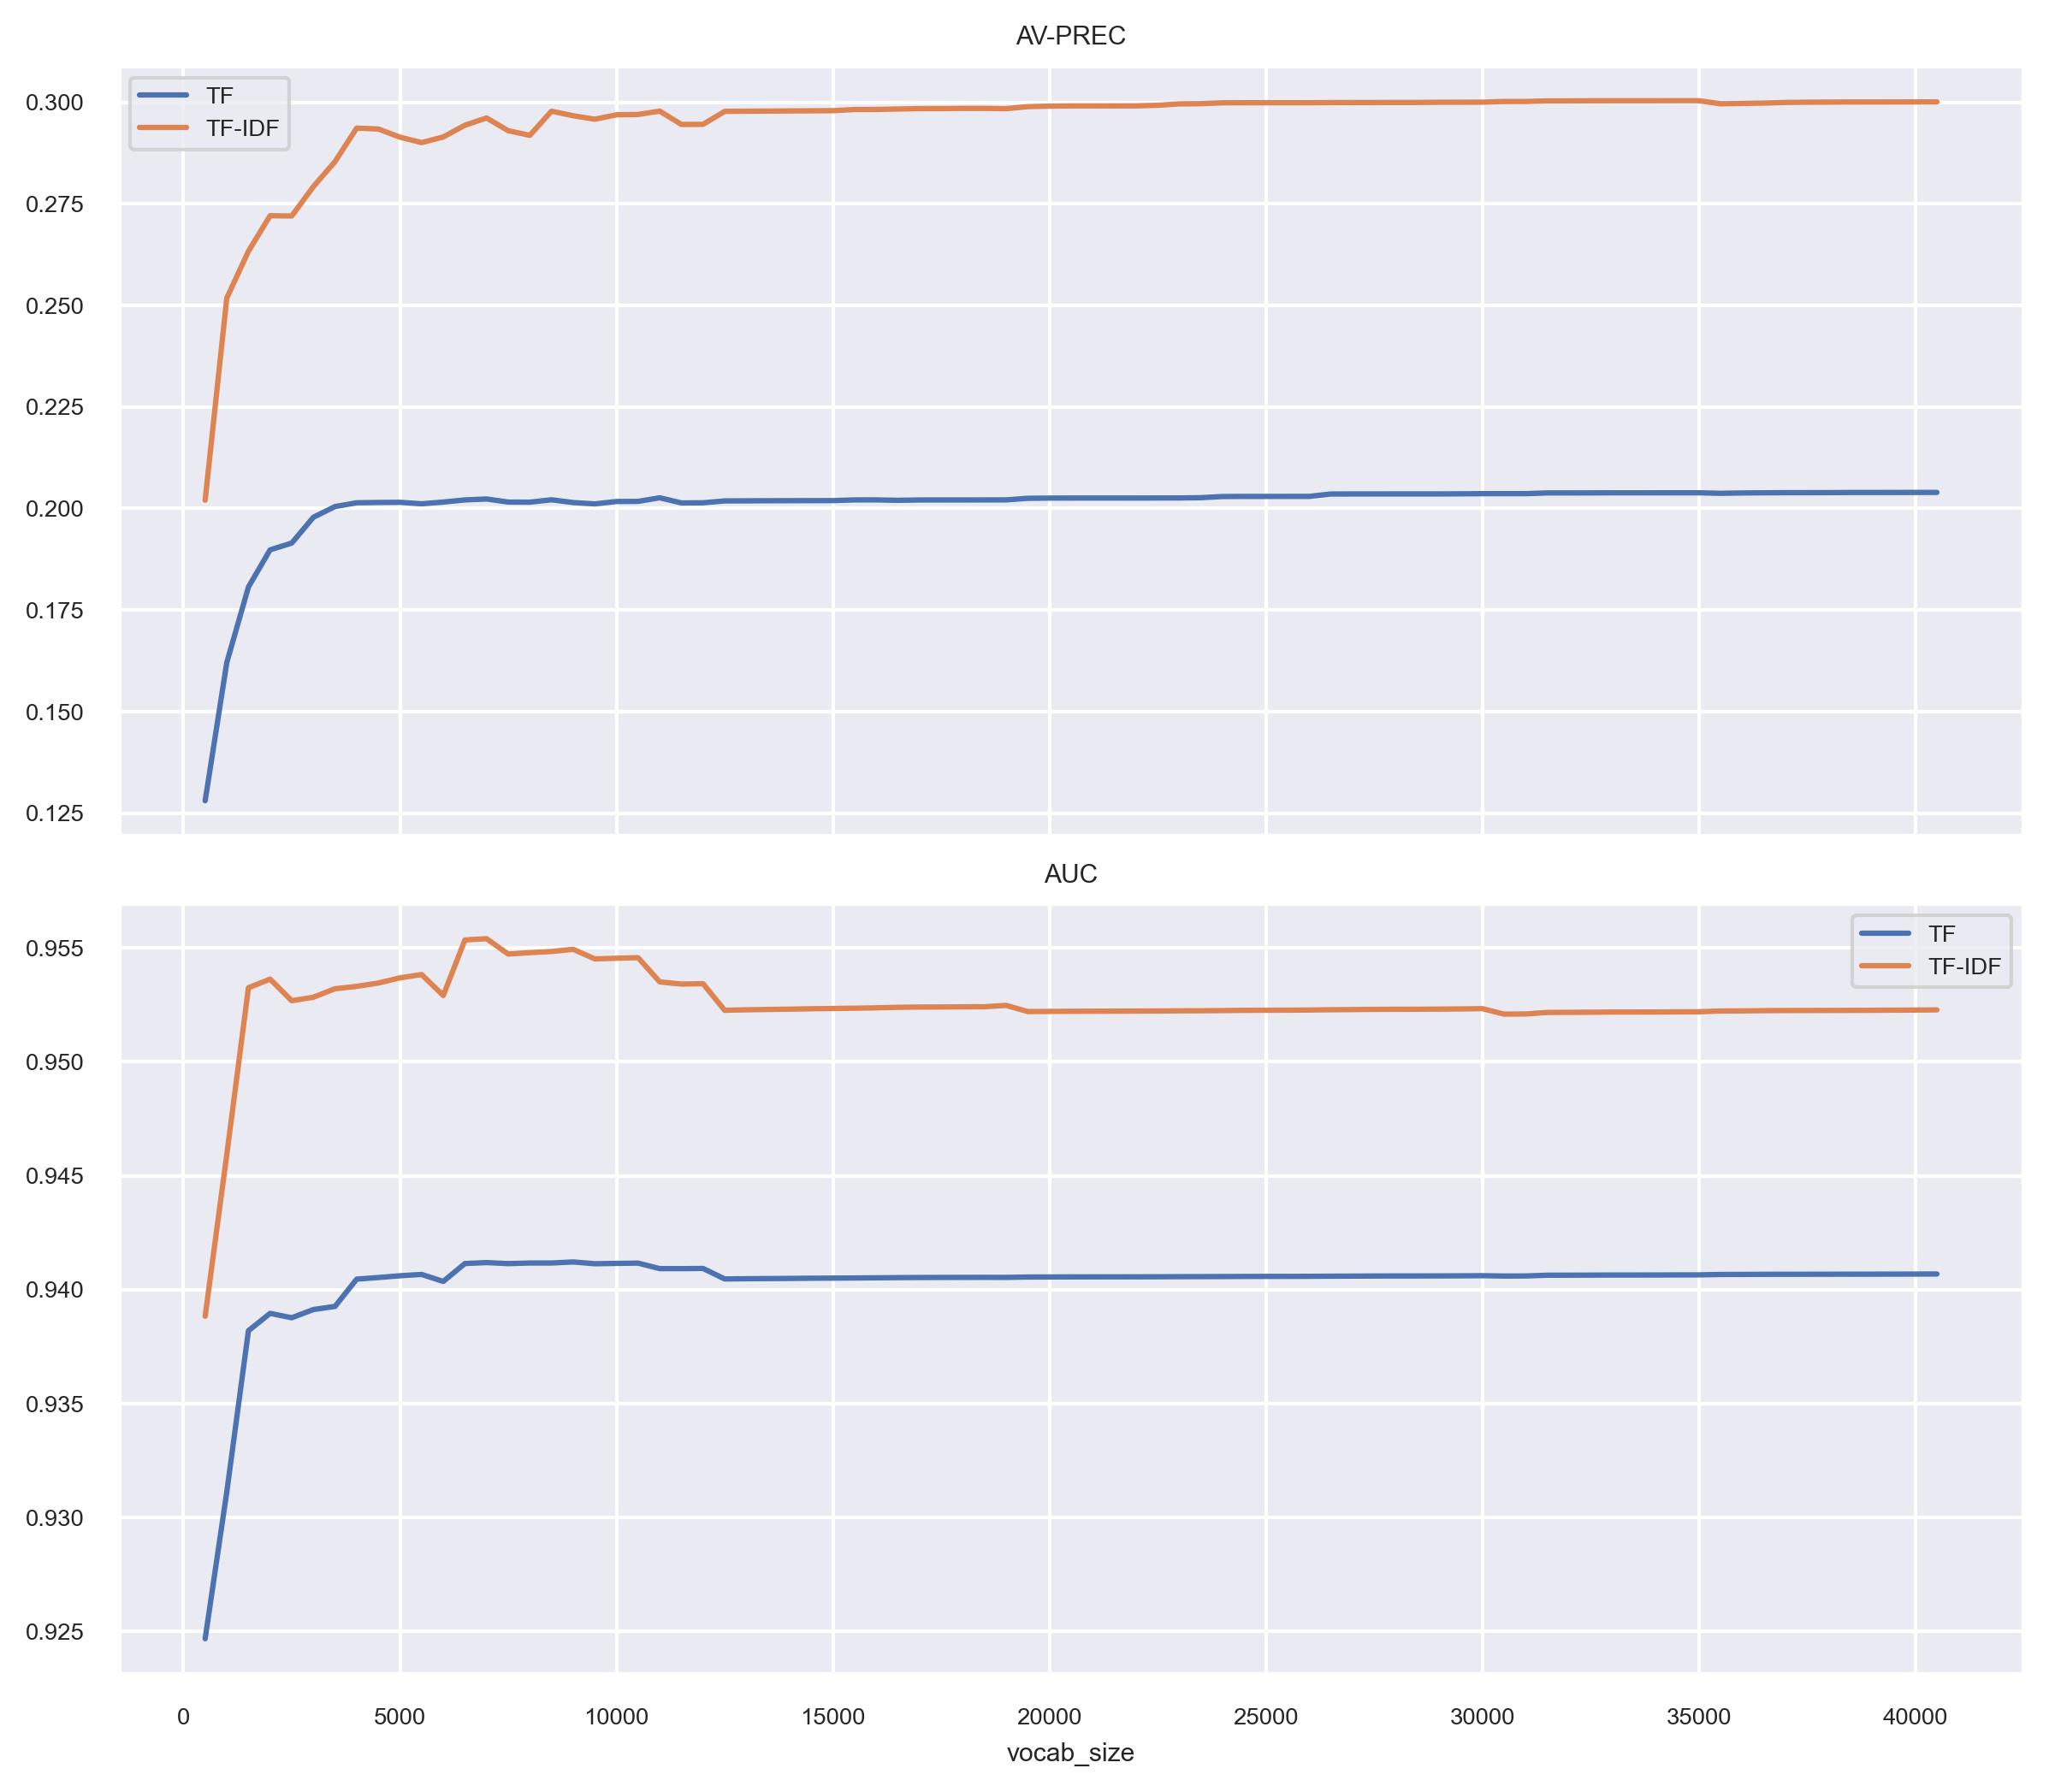

In [38]:
scores = pd.DataFrame(scores, columns=('param', 'vocab_size', 'AUC', 'AV-PREC'))

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 7))

for p, gr in scores.groupby('param'):
    gr.plot('vocab_size', 'AV-PREC', label=p, ax=ax1)
ax1.set_title('AV-PREC')
    
for p, gr in scores.groupby('param'):
    gr.plot('vocab_size', 'AUC', label=p, ax=ax2)
ax2.set_title('AUC')

plt.tight_layout()
plt.savefig(f'{fig_dir}/vocab_size.png', transparent=True);

In [39]:
scores['comb'] = scores['AUC'] * scores['AV-PREC']
optim_vs = scores.iloc[scores['AUC'].idxmax()]
display(optim_vs)
optim_vs = optim_vs['vocab_size']

param         TF-IDF  
vocab_size    7000    
AUC           0.955405
AV-PREC       0.296145
comb          0.282939
Name: 26, dtype: object

In [30]:
optim_vs = 7000
optim_rw = 0.1693877551020408

## Final threshold

max(f1)=0.3607 @ theta=0.578


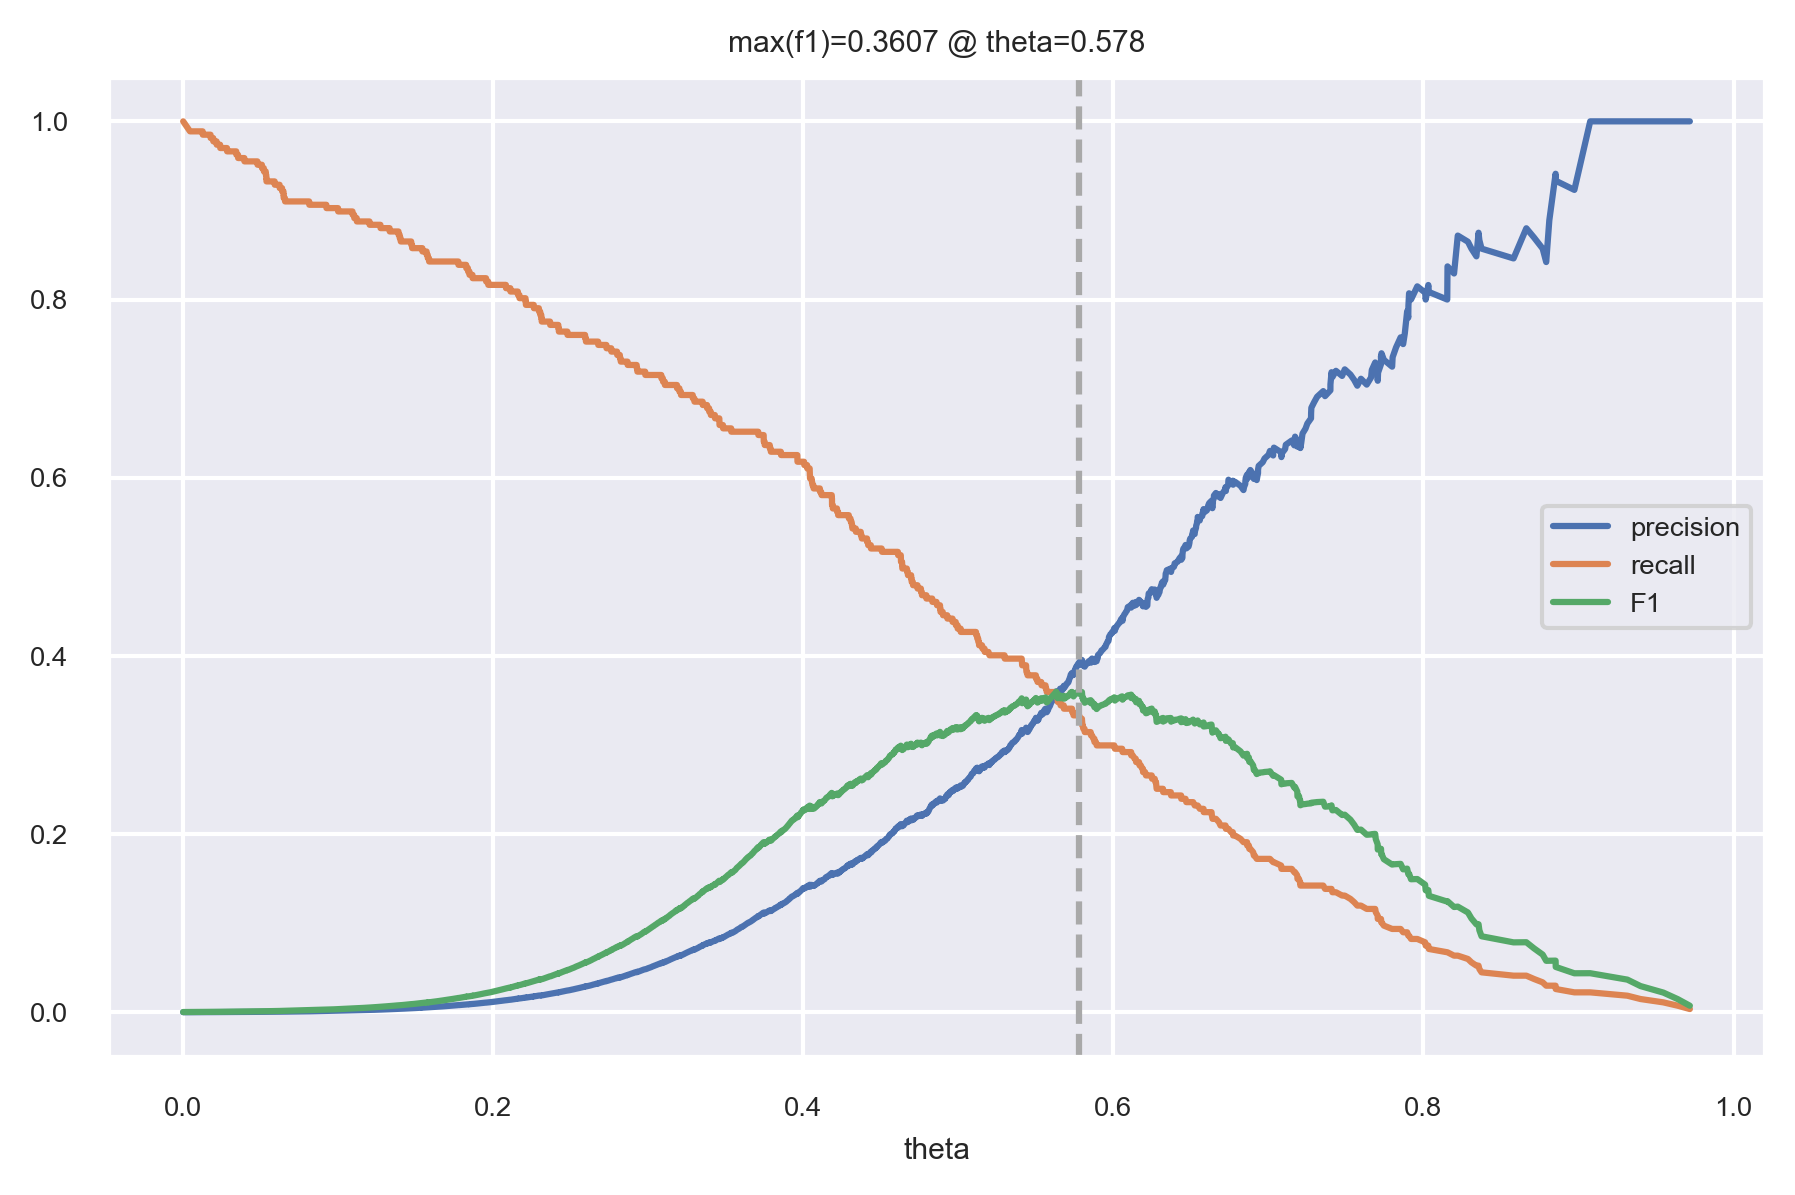

In [31]:
vec = TfidfVectorizer(max_features=optim_vs, min_df=2,
                      tokenizer=tokenizer, token_pattern=None).fit(df['lemmas'])
relevances, distances = precision_recall(df, meta, vec, rhyme_weight=optim_rw)
distances = 1 - np.array(distances)
precisions, recalls, thresholds = precision_recall_curve(relevances, distances)
f1s = (2 * precisions * recalls) / (precisions + recalls)

max_f1_idx = np.array(f1s).argmax()
max_f1 = f1s[max_f1_idx]
max_f1_th = thresholds[max_f1_idx]
print(f'max(f1)={round(max_f1, 4)} @ theta={round(max_f1_th, 4)}')

plt.plot(thresholds, precisions[:-1], label='precision')
plt.plot(thresholds, recalls[:-1], label='recall')
plt.plot(thresholds, f1s[:-1], label='F1')
plt.axvline(max_f1_th, ls='--', c='darkgrey')
plt.gca().set_xlabel('theta')
plt.gca().legend()
plt.title(f'max(f1)={round(max_f1, 4)} @ theta={round(max_f1_th, 4)}')
plt.tight_layout()

plt.tight_layout()
plt.savefig(f'{fig_dir}/threshold.png', transparent=True);

## Case studies

#### Well-known cases of intertextual borrowings at the MACRO-level

In [32]:
def batch(iterable, n=1):
    l = iterable.shape[0]
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

def pairwise(title1, title2, rhyme_weight=.25, batch_size=5000):
    
    A = df[df['title'] == title1]
    B = df[df['title'] == title2]

    AX = vec.transform(A['lemmas']) + rhyme_weight * vec.transform(A['rhyme'])
    BX = vec.transform(B['lemmas']) + rhyme_weight * vec.transform(B['rhyme'])

    all_distances = None

    for ax in batch(AX, batch_size):
        if all_distances is None:
            all_distances = pairwise_distances(ax, BX, metric='cosine')
        else:
            all_distances = np.append(all_distances,
                                      pairwise_distances(ax, BX, metric='cosine'),
                                      axis=0)
    
    return all_distances

def retrieve_intertexts(title1, title2, distances, threshold):
    A = df[df['title'] == title1]
    B = df[df['title'] == title2]
    
    intertexts = []
    for idx1, idx2 in np.transpose(np.nonzero(distances < threshold)):
        tokens1 = A.iloc[idx1]['tokens']
        tokens2 = B.iloc[idx2]['tokens']
        distance = distances[idx1, idx2]
        intertexts.append((title1, title2, tokens1, tokens2, distance))
        
    return pd.DataFrame(intertexts, columns=['title1', 'title2', 'tokens1', 'tokens2', 'distance'])

def plot_min_distance_nn(t1, t2, min_dists, threshold, rolling_size=1000):
    mu = min_dists.rolling(rolling_size).mean()
    fig, ax = plt.subplots()
    mu.plot(ax=ax)
    ax.axhline(threshold, ls='--', c='grey')
    ax.set_ylim(0, 1)
    ax.set_xlabel(t1)
    ax.set_ylabel('Distance to NN in ' + t2)
    return ax

In [33]:
rolling_size, threshold = 1000, 1 - max_f1_th
print(threshold)

0.42202047865566794


In [34]:
def get_interpolations(title):
    fn = meta_df[meta_df['title'] == title]['id'].iloc[0]
    tree = lxml.etree.parse(f'../data/xml/{fn}.xml').getroot()
    interpol_idxs, interpol_names, line_cnt = [], [], 0
    for element in tree:
        line_cnt += 1
        if element.tag == 'interpolation':
            idxs, length = line_cnt, len(element.findall('l'))
            interpol_idxs.append([line_cnt, line_cnt + length])
            line_cnt += length
            interpol_names.append(element.attrib['reason'])      
    return interpol_idxs, interpol_names

Heelu in de Vijfde Partie:

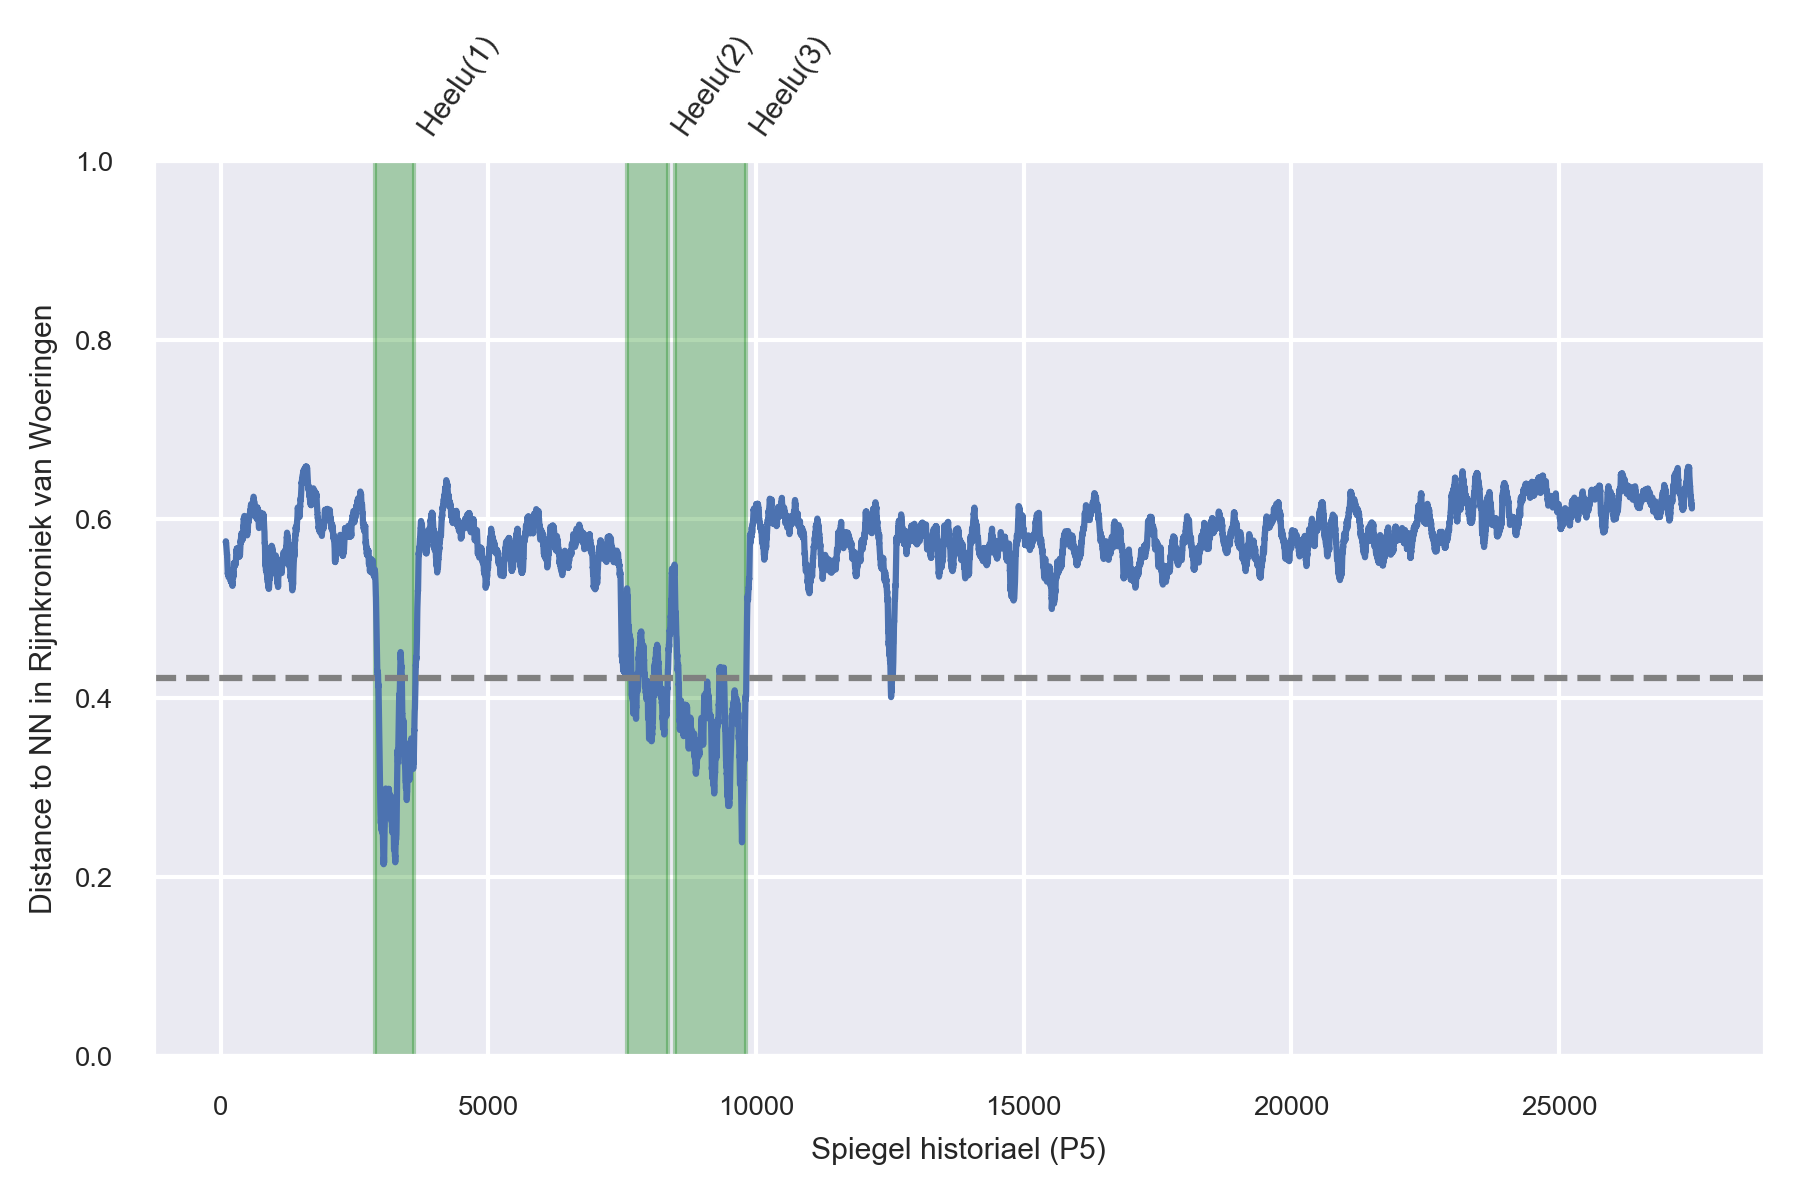

In [35]:
t1, t2 = 'Spiegel historiael (P5)', 'Rijmkroniek van Woeringen'
distances = pairwise(t1, t2, rhyme_weight=optim_rw)
min_dists = pd.Series(distances.min(axis=1))
ax = plot_min_distance_nn(t1, t2, min_dists, threshold=threshold, rolling_size=100)
interpol_idxs, interpol_names = get_interpolations(t1)
for (start, end), n in zip(interpol_idxs, interpol_names):
    if n.startswith('Heelu'):
        ax.axvspan(start, end, alpha=0.3, color='green', lw=1)
        plt.annotate(n, xy=[end, 1.03], annotation_clip=False, rotation=55)
plt.tight_layout()
plt.savefig(f'{fig_dir}/heelu.png', transparent=True);

Maerlant in de Brabantse yeesten:

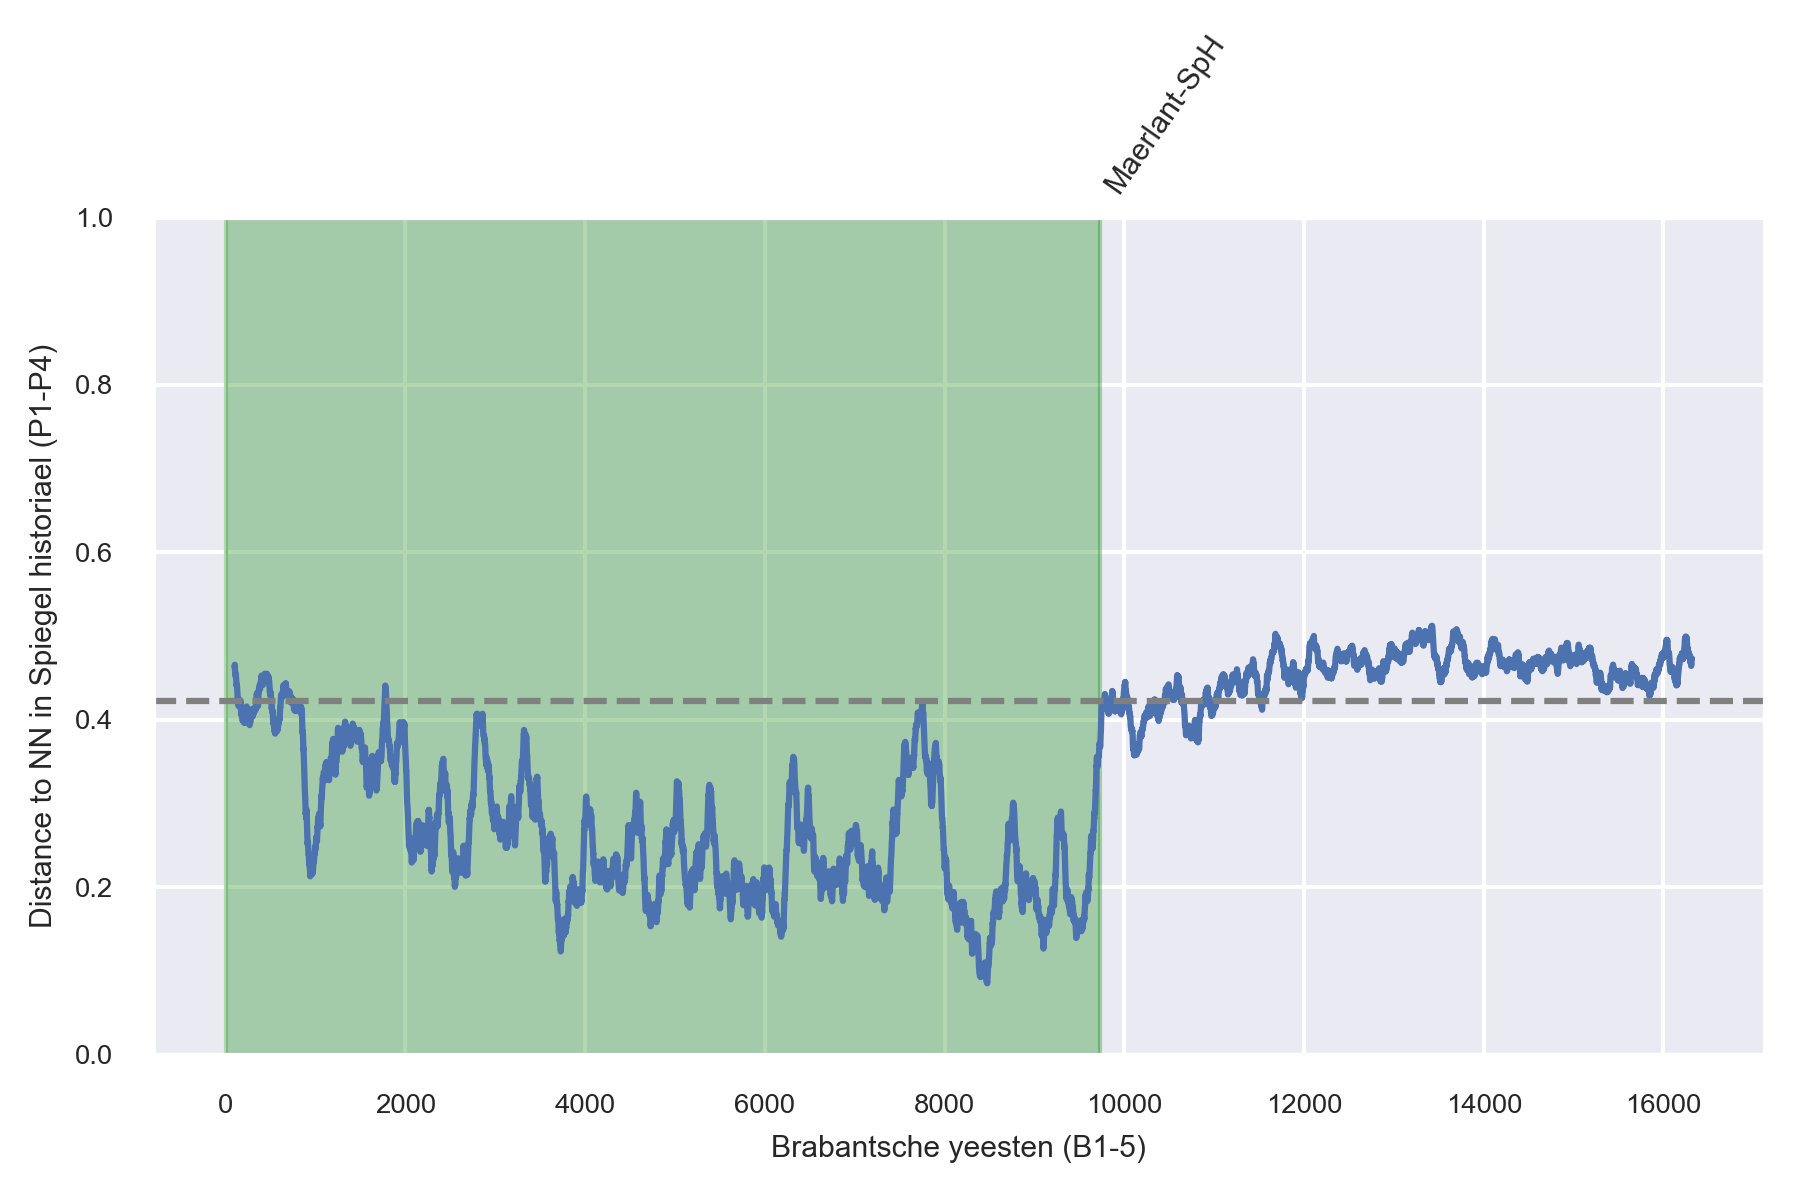

In [36]:
t1, t2 = 'Brabantsche yeesten (B1-5)', 'Spiegel historiael (P1-P4)'
distances = pairwise(t1, t2, rhyme_weight=optim_rw)
min_dists = pd.Series(distances.min(axis=1))
ax = plot_min_distance_nn(t1, t2, min_dists, threshold=threshold, rolling_size=100);
interpol_idxs, interpol_names = get_interpolations(t1)
for (start, end), n in zip(interpol_idxs, interpol_names):
    ax.axvspan(start, end, alpha=0.3, color='green', lw=1)
    plt.annotate(n, xy=[end, 1.03], annotation_clip=False, rotation=55)
plt.tight_layout()
plt.savefig(f'{fig_dir}/yeesten.png', transparent=True);

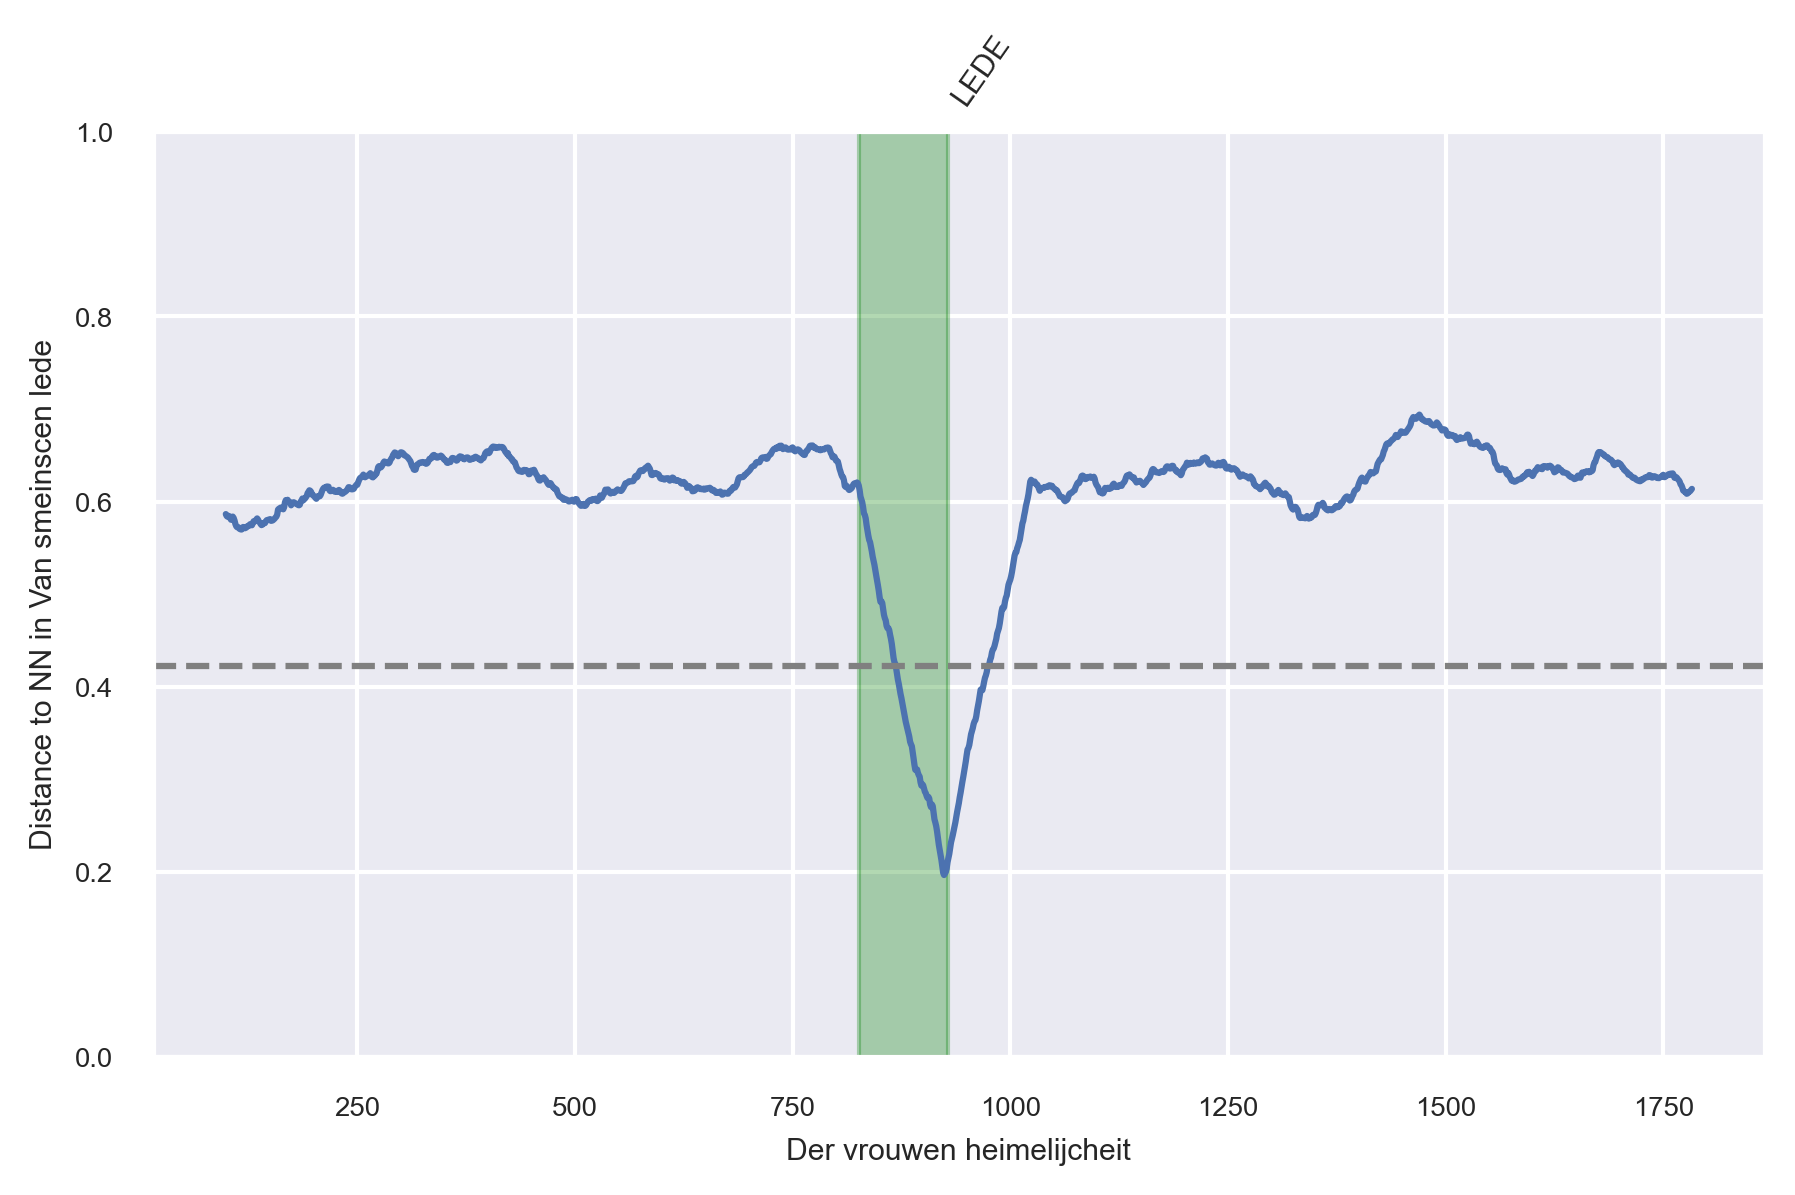

In [37]:
t1, t2 = 'Der vrouwen heimelijcheit', 'Van smeinscen lede'
distances = pairwise(t1, t2, rhyme_weight=optim_rw)
min_dists = pd.Series(distances.min(axis=1))
ax = plot_min_distance_nn(t1, t2, min_dists, threshold=threshold, rolling_size=100);
interpol_idxs, interpol_names = get_interpolations(t1)
for (start, end), n in zip(interpol_idxs, interpol_names):
    ax.axvspan(start, end, alpha=0.3, color='green', lw=1)
    plt.annotate(n, xy=[end, 1.03], annotation_clip=False, rotation=55)
plt.tight_layout()
plt.savefig(f'{fig_dir}/heimelijcheit.png', transparent=True);

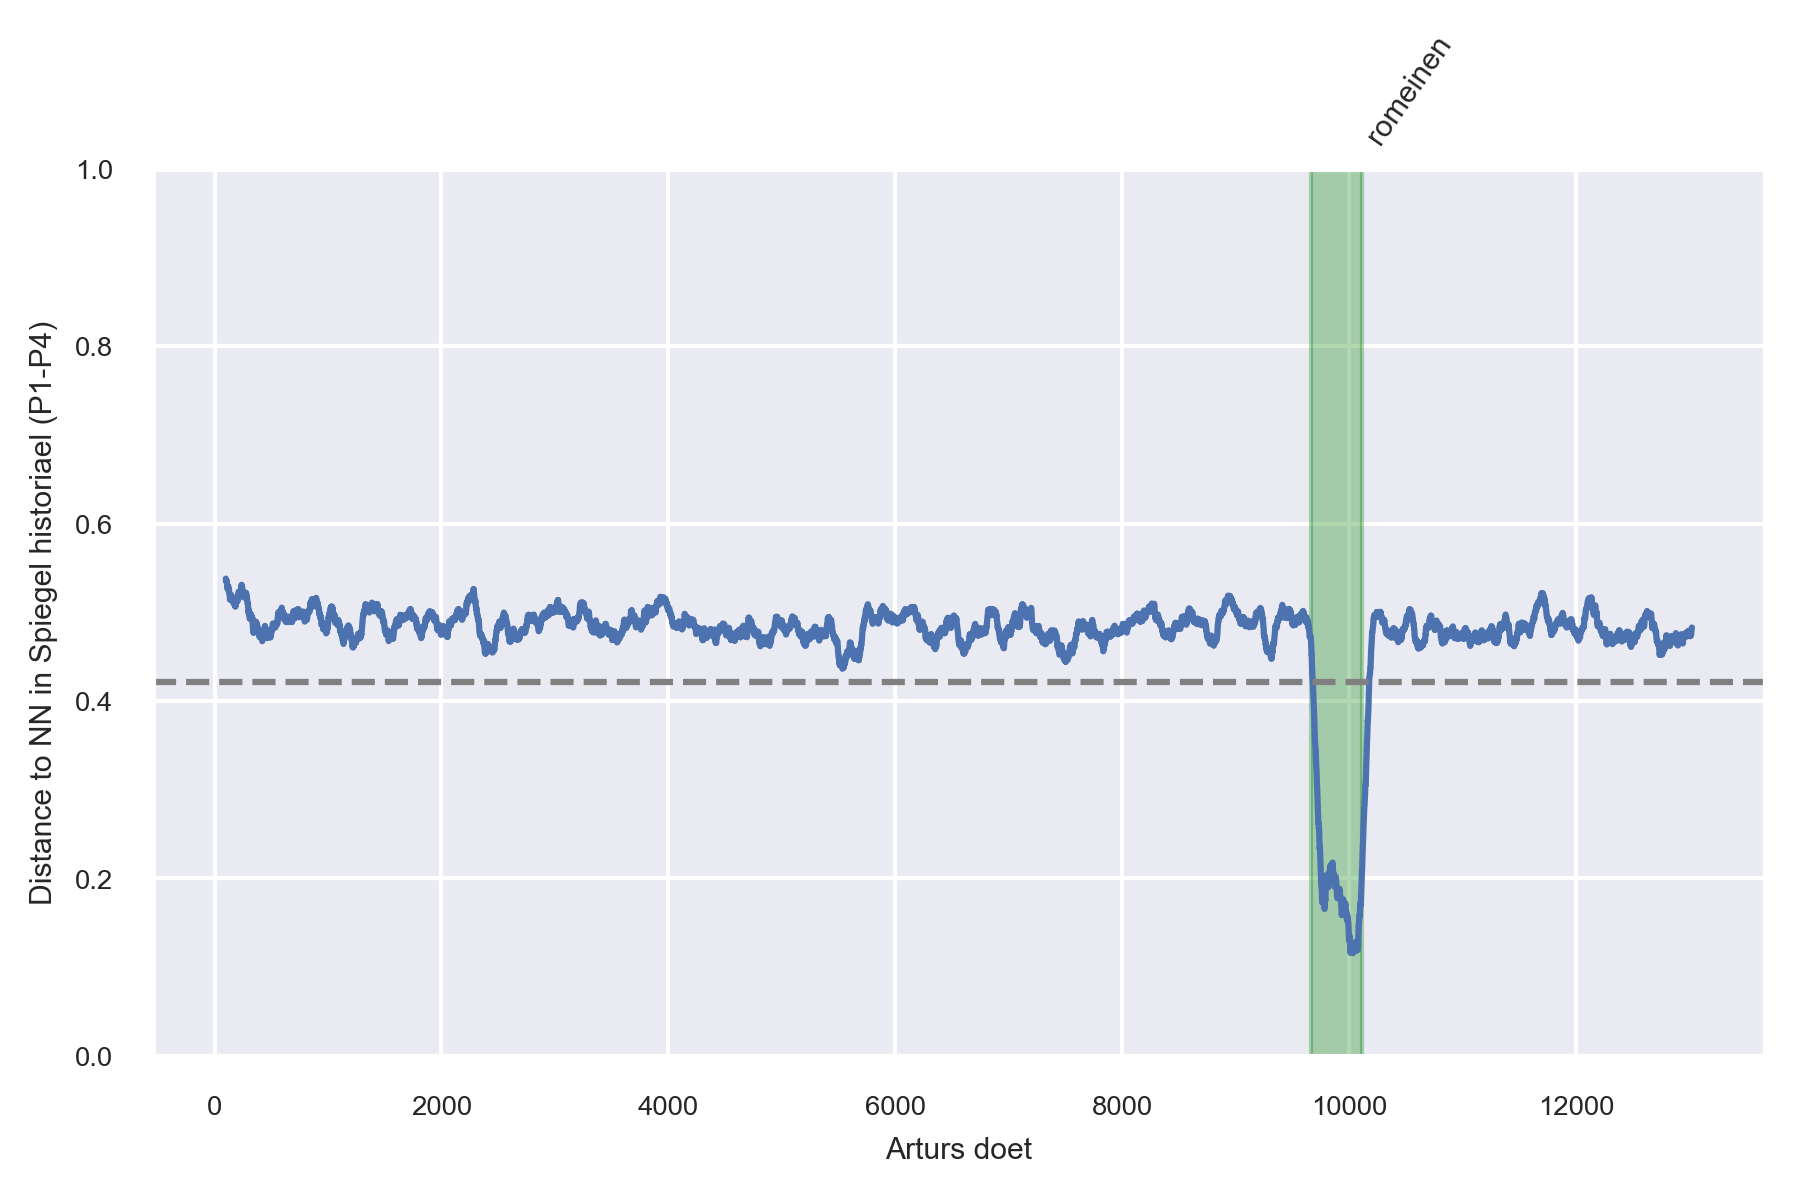

In [38]:
t1, t2 = 'Arturs doet', 'Spiegel historiael (P1-P4)'
distances = pairwise(t1, t2, rhyme_weight=optim_rw)
min_dists = pd.Series(distances.min(axis=1))
ax = plot_min_distance_nn(t1, t2, min_dists, threshold=threshold, rolling_size=100);
interpol_idxs, interpol_names = get_interpolations(t1)
for (start, end), n in zip(interpol_idxs, interpol_names):
    if not 'gebed' in n:
        ax.axvspan(start, end, alpha=0.3, color='green', lw=1)
        plt.annotate(n, xy=[end, 1.03], annotation_clip=False, rotation=55)
plt.tight_layout()
plt.savefig(f'{fig_dir}/romeinen.png', transparent=True);

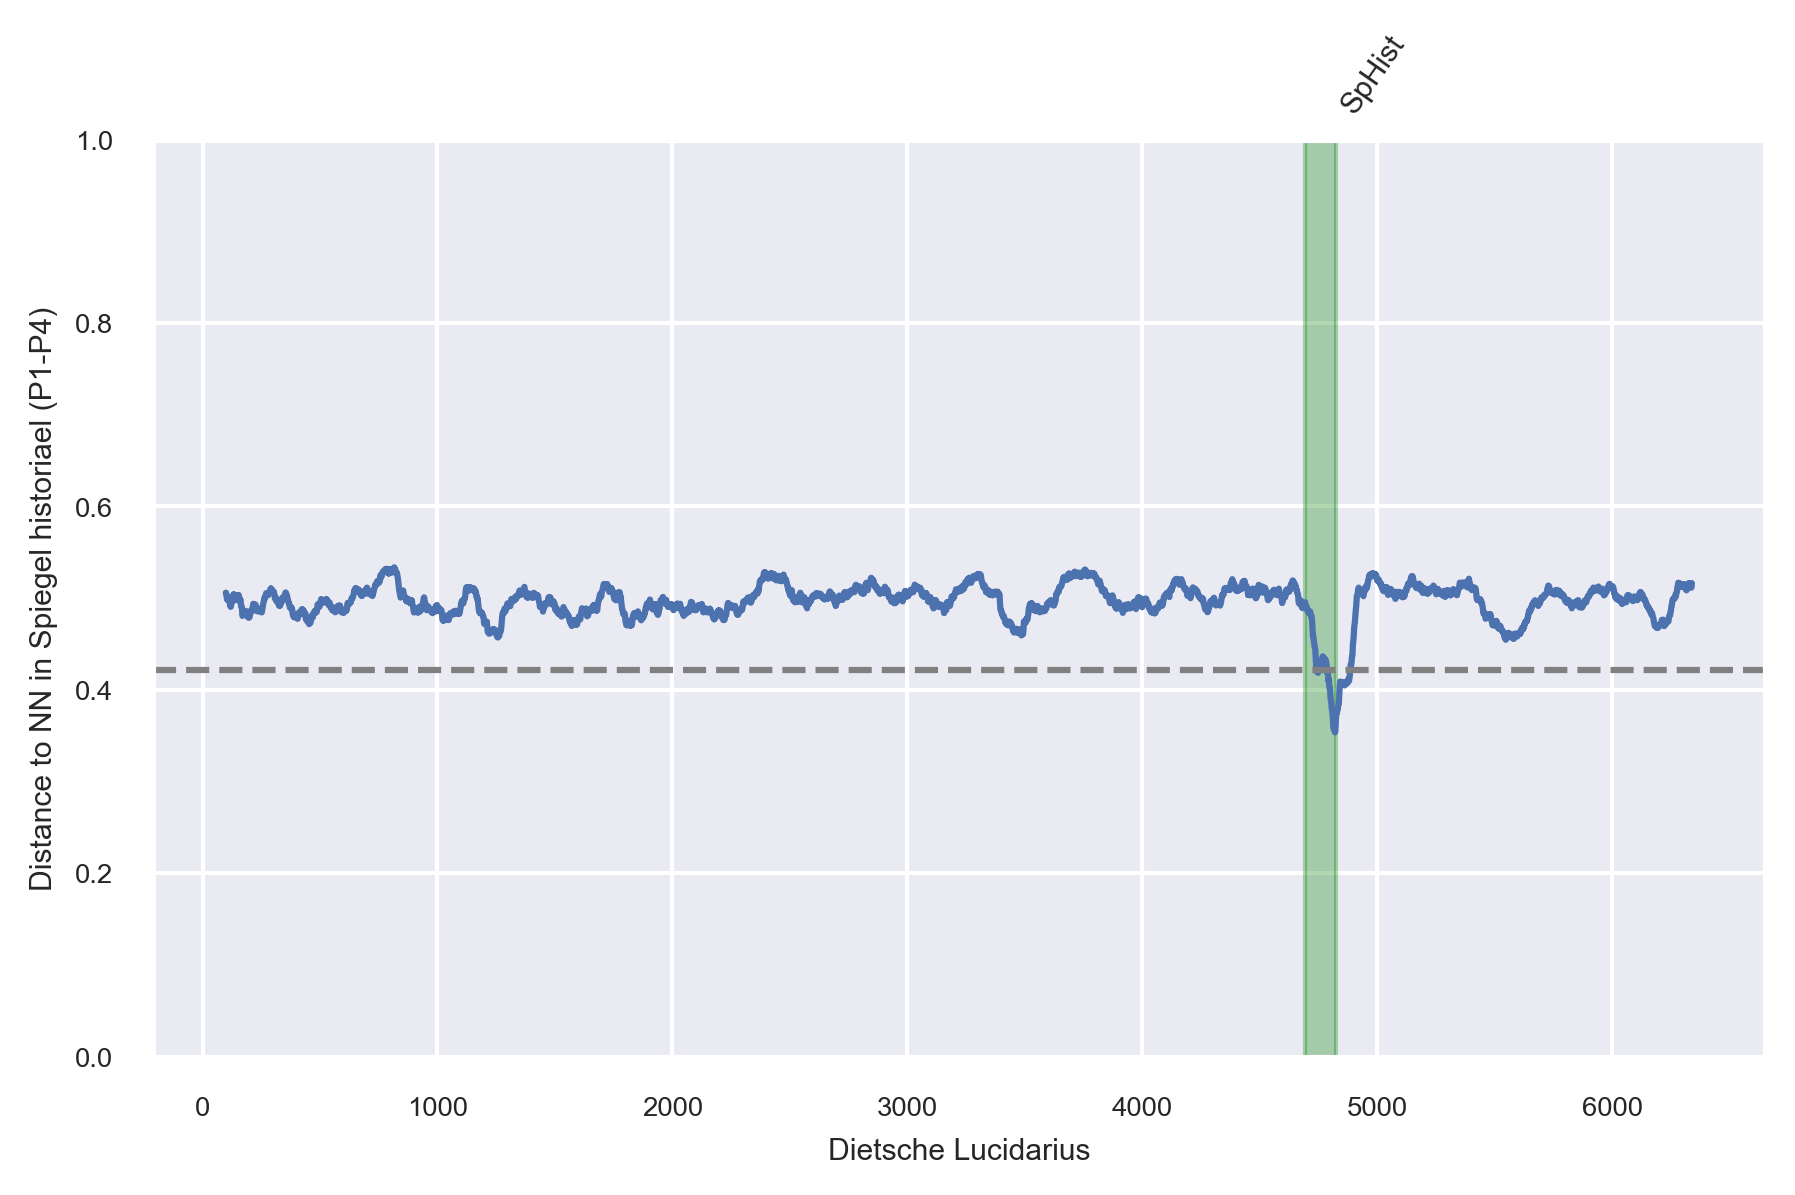

In [39]:
t1, t2 = 'Dietsche Lucidarius', 'Spiegel historiael (P1-P4)'
distances = pairwise(t1, t2, rhyme_weight=optim_rw)
min_dists = pd.Series(distances.min(axis=1))
ax = plot_min_distance_nn(t1, t2, min_dists, threshold=threshold, rolling_size=100);
interpol_idxs, interpol_names = get_interpolations(t1)
for (start, end), n in zip(interpol_idxs, interpol_names):
    if 'SpHist' in n:
        ax.axvspan(start, end, alpha=0.3, color='green', lw=1)
        plt.annotate(n, xy=[end, 1.03], annotation_clip=False, rotation=55)
plt.tight_layout()
plt.savefig(f'{fig_dir}/lucidarius_sphist.png', transparent=True);

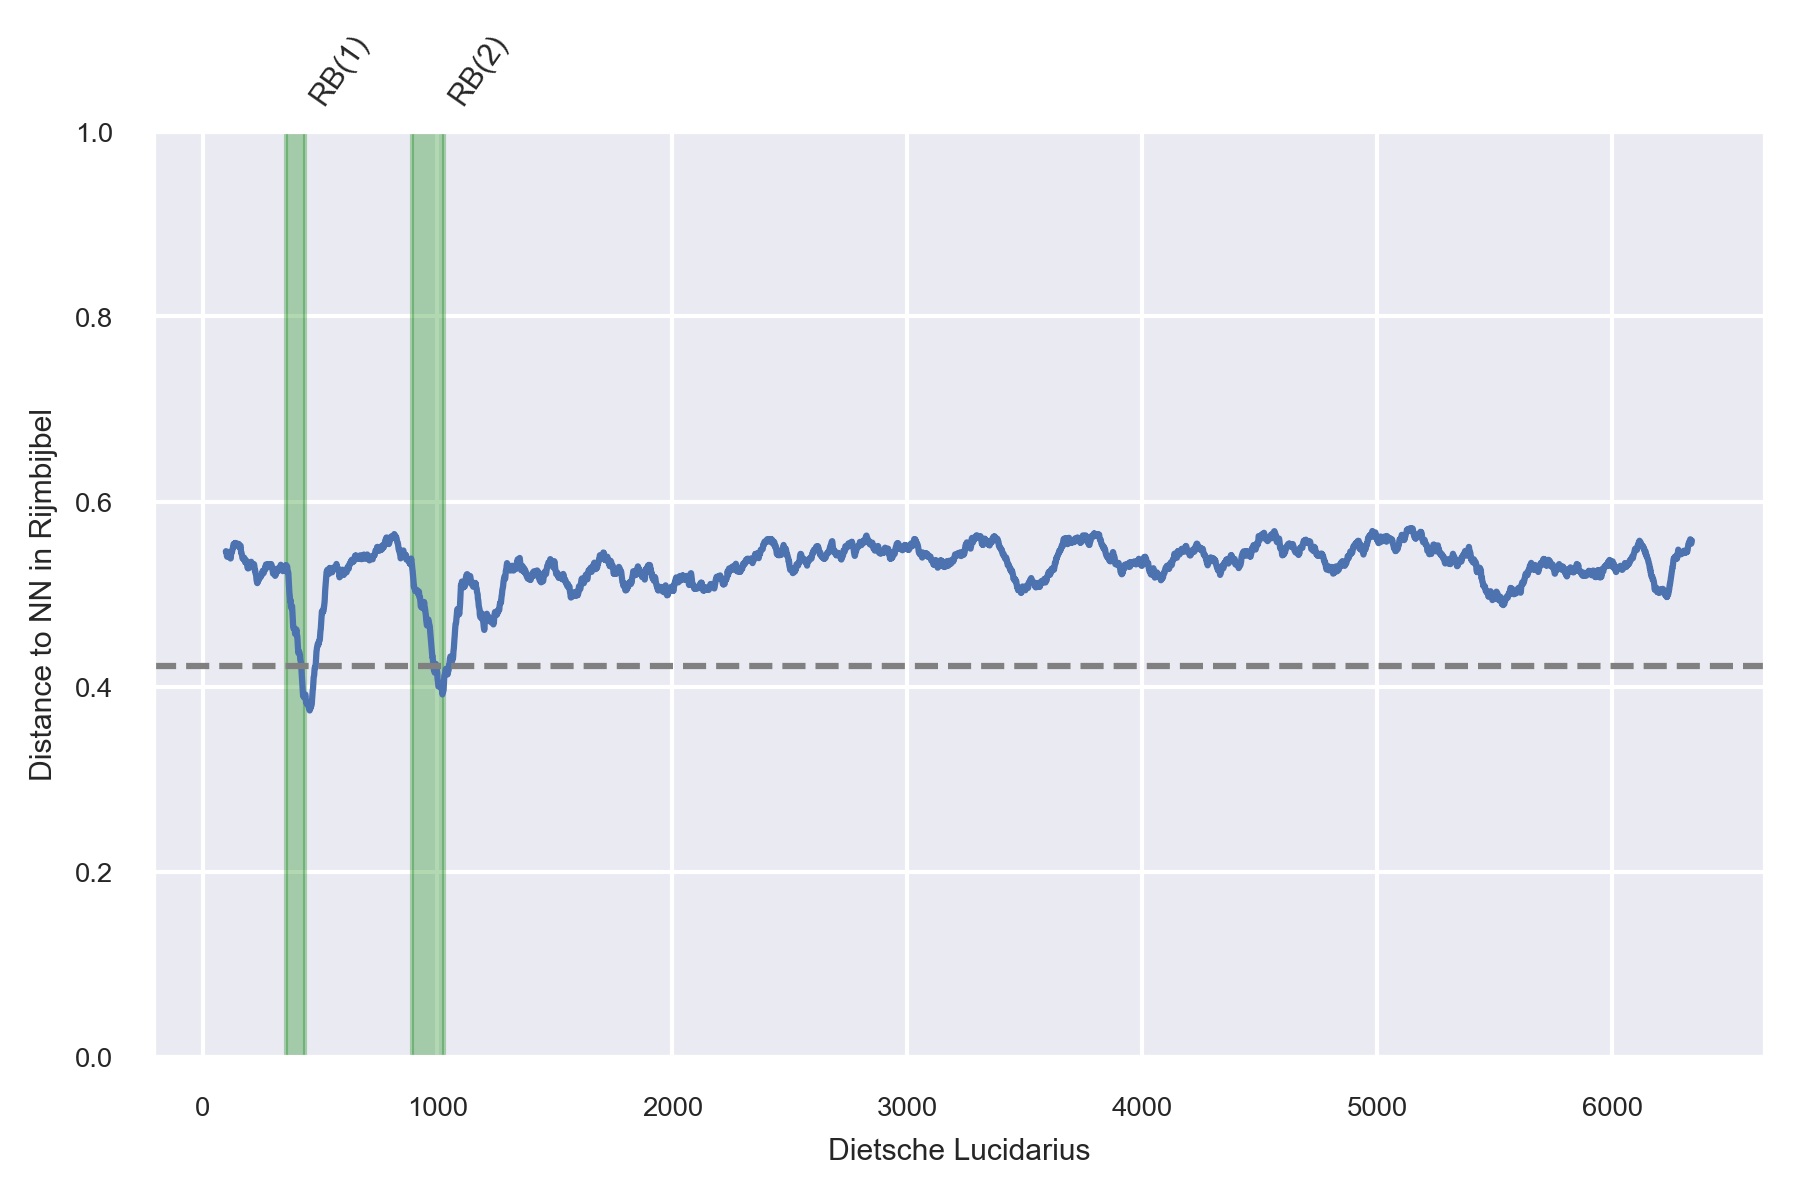

In [40]:
t1, t2 = 'Dietsche Lucidarius', 'Rijmbijbel'
distances = pairwise(t1, t2, rhyme_weight=optim_rw)
min_dists = pd.Series(distances.min(axis=1))
ax = plot_min_distance_nn(t1, t2, min_dists, threshold=threshold, rolling_size=100);
interpol_idxs, interpol_names = get_interpolations(t1)
for (start, end), n in zip(interpol_idxs, interpol_names):
    if not 'SpHist' in n:
        ax.axvspan(start, end, alpha=0.3, color='green', lw=1)
        plt.annotate(n, xy=[end, 1.03], annotation_clip=False, rotation=55)
plt.tight_layout()
plt.savefig(f'{fig_dir}/lucidarius_rb.png', transparent=True);

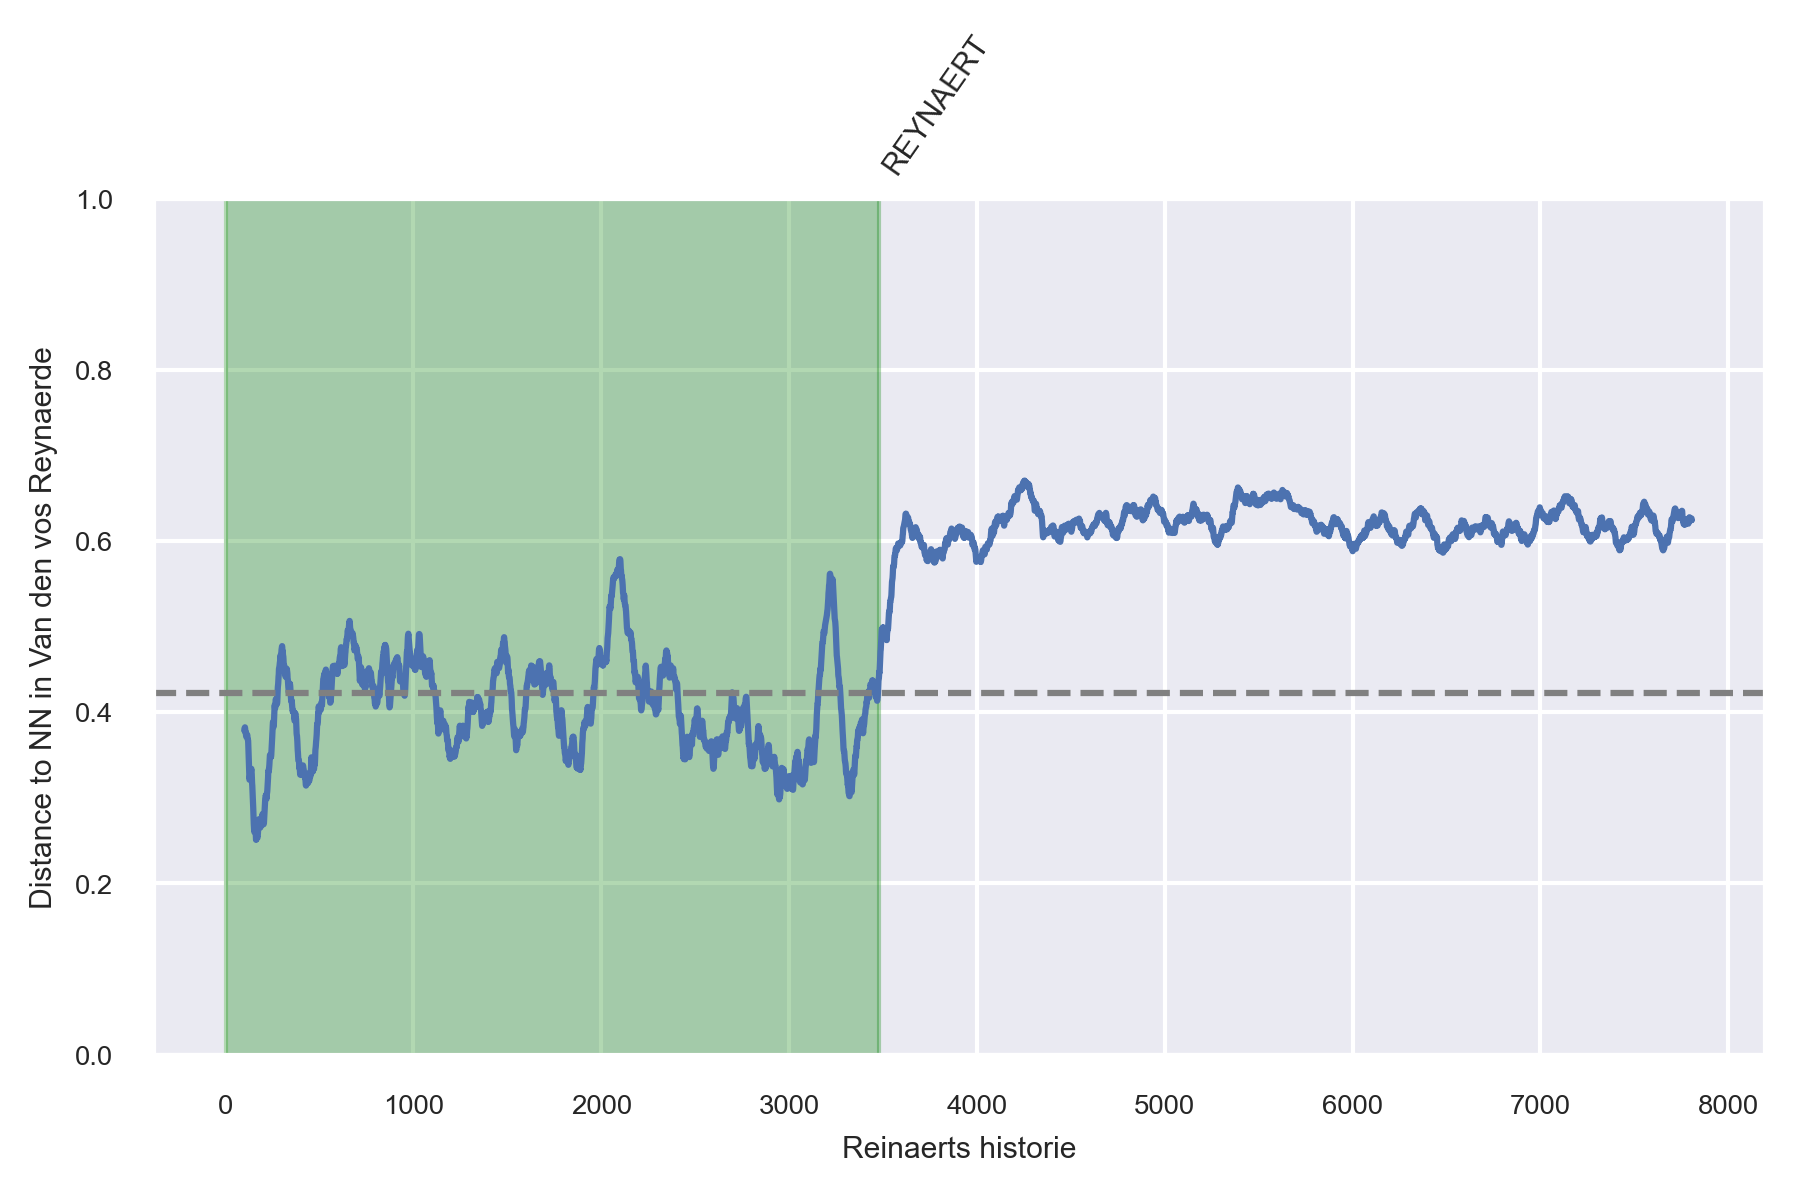

In [41]:
t1, t2 = 'Reinaerts historie', 'Van den vos Reynaerde'
distances = pairwise(t1, t2, rhyme_weight=optim_rw)
min_dists = pd.Series(distances.min(axis=1))
ax = plot_min_distance_nn(t1, t2, min_dists, threshold=threshold, rolling_size=100);
interpol_idxs, interpol_names = get_interpolations(t1)
for (start, end), n in zip(interpol_idxs, interpol_names):
    if not 'gebed' in n:
        ax.axvspan(start, end, alpha=0.3, color='green', lw=1)
        plt.annotate(n, xy=[end, 1.03], annotation_clip=False, rotation=55)
plt.tight_layout()
plt.savefig(f'{fig_dir}/reinaert.png', transparent=True);

(Show some random combinations of Maerlant works to show the many intertexts in a oeuvre!)

#### Large-scale detection

In [115]:
chiv_titles = meta_df[meta_df['genre'] == 'Epiek']['title'].unique()
chiv_titles

array(['Alexanders geesten', 'Alexiuslegende', 'Anatomie van de mens',
       'Arturs doet', 'Aubri de Borgengoen', 'Barlaam en Josaphat',
       'Beatrijs', 'Bediedenisse van der missen',
       'Beerte metten breden voeten', 'Beginsel der oorlogen van Luyck',
       'Boec Exemplaer', 'Boec van den houte', 'Boec vander wraken',
       'Boeve van Hamtone', 'Borchgrave van Couchi',
       'Borchgravinne van Vergi (1)', 'Borchgravinne van Vergi (2)',
       'Boudewijn van Seborch', 'Brabantsche yeesten (B1-5)',
       'Brabantsche yeesten (B6)', 'Brabantsche yeesten (B7)',
       'Nevelingenlied', "Chanson d'Aspremont", 'Collectief lunarium I',
       'Collectief lunarium III', 'Commentaar op het Hooglied',
       'Collectief lunarium II', 'Cyromanchie van den pape van den Hamme',
       'Der leken spieghel', 'Der mannen ende vrouwen heimelijcheit',
       'Der minnen loep', 'Der naturen bloeme',
       'Der vrouwen heimelijcheit', 'Der ystorien bloeme',
       'Dietsche doctrinale', 'Di

In [52]:
results = []
for t1, t2 in tqdm(list(product(chiv_titles, chiv_titles))):
    if t1 == t2:
        continue
    distances = pairwise(t1, t2, rhyme_weight=optim_rw, batch_size=10000)
    min_dists = pd.Series(distances.min(axis=1))
    results.append((t1, t2, min_dists))

  7%|▋         | 1805/25921 [13:19<2:58:06,  2.26it/s]


KeyboardInterrupt: 

In [ ]:
results = pd.DataFrame(results, columns=('t1', 't2', 'nn'))
results

In [ ]:
rolling_size = 100
for _, r in results.iterrows():
    if np.any(r['nn'].rolling(rolling_size).mean() < threshold):
        plot_min_distance_nn(r['t1'], r['t2'], r['nn'],
                             threshold=threshold, rolling_size=rolling_size);

Remarkable intertexts between:
- Lorreinen
- Limborch
- Rijmkroniek van Woeringen - Grimbergse oorlog: maar veelal beperkt tot strijdformules die telkens herhaald worden

## Meso-scale intertextuality

Case studies in sutbler intertextual connections as the MESO-scale. Fro this, we set the rhyme weight to 0.
- Prieel-scene Limborch vs Historie van Troyen
- River scene: Walewein vs Moriaen
- Hart-scene Ferguut vs Limborch

In [53]:
def load_meso_text(fn, title, group_size=None):
    work_tokens, work_lemmas = [], []
    for tok, lem, intertext_id in parse_xml(fn):
        work_tokens.append(tok)
        work_lemmas.append(lem)

    verse_tokens = [' '.join(v) for v in work_tokens]
    verse_lemmas = [' '.join(v) for v in work_lemmas]
    
    if not group_size:
        group_size = len(verse_tokens)

    verse_group_tokens = list(get_verse_groups(verse_tokens, size=group_size))
    verse_group_lemmas = list(get_verse_groups(verse_lemmas, size=group_size))
    
    meso = pd.DataFrame(zip([title] * len(verse_group_tokens), verse_group_tokens, verse_group_lemmas),
                      columns=('title', 'tokens', 'lemmas'))
    meso = add_rhyme_column(meso)
    
    return group_size, meso

def top_meso(A, B, rhyme_weight, k=3):
    AX = vec.transform(A['lemmas']) + rhyme_weight * vec.transform(A['rhyme'])
    BX = vec.transform(B['lemmas']) + rhyme_weight * vec.transform(B['rhyme'])
    D = pd.Series(pairwise_distances(BX, AX, metric='cosine').min(axis=1))
    top_idxs = D.argsort()[:k]
    top_hits = B.iloc[top_idxs].copy()
    top_hits['distance'] = D[top_idxs]
    return top_hits

In [54]:
group_size, prieel = load_meso_text(fn='../data/meso/prieel.xml', title='Prieel')
_, HvT = load_meso_text(fn='../data/xml/roman_van_limborch.xml', title='Limborch',
                        group_size=group_size)
top_meso(prieel, HvT, rhyme_weight=0, k=20)

,title,tokens,lemmas,rhyme,distance
7369,Limborch,Soe langhe reet die ridder coene / Dat hi een marghens vor noene / Quam in enen sconen vergier / In midden stont enen eglentier / Boven ene scone fonteyne / Soudic al die sconeit reyne / Prisen het ware mi te swaer / Die fonteyne was oec soe claer / Dat wonder te seggen ware / Die ridder peinsde eer ic vort vare / Willic mi hier een luttel rusten / Het mochts elken mensce lusten / Te rustene in alsoe sconer stede / Hi beete neder ende dede / Siin ors peistren gaen int gras,zo lang rijden de ridder koen / dat hij een morgen voor noen / komen in een schoon vergier / in midden staan een eglendier / boven een schoon fontein / ik zullen al de schoonheid rein / prijzen het zijn ik te zwaar / de fontein zijn ook zo klaar / dat wonder te zeggen zijn / de ridder peinzen eer ik voort varen / ik willen ik hier een luttel rusten / het mogen elk mens lusten / te rusten in alzo schoon stad / hij beten neder en doen / zijn hors peister gaan het in gras,koen noen vergier eglendier fontein rein zwaar klaar zijn varen rusten lusten stad doen gras,0.665624
7363,Limborch,Ende voeren te Grieken waert / Nu latic staen van hare vaert / Ende seggu van Echites voert / Dien de minne sere cort / Ende reet berch ende dal / Gode hi hem altoes beval / Soe langhe reet die ridder coene / Dat hi een marghens vor noene / Quam in enen sconen vergier / In midden stont enen eglentier / Boven ene scone fonteyne / Soudic al die sconeit reyne / Prisen het ware mi te swaer / Die fonteyne was oec soe claer / Dat wonder te seggen ware,en varen te n(prop) waart / nu ik laten staan van haar vaart / en zeggen du van ethites voorts / die de minne zeer kort / en rijden berg en dal / n(prop) hij hij altoos bevelen / zo lang rijden de ridder koen / dat hij een morgen voor noen / komen in een schoon vergier / in midden staan een eglendier / boven een schoon fontein / ik zullen al de schoonheid rein / prijzen het zijn ik te zwaar / de fontein zijn ook zo klaar / dat wonder te zeggen zijn,waart vaart voorts kort dal bevelen koen noen vergier eglendier fontein rein zwaar klaar zijn,0.669335
7370,Limborch,Dat hi een marghens vor noene / Quam in enen sconen vergier / In midden stont enen eglentier / Boven ene scone fonteyne / Soudic al die sconeit reyne / Prisen het ware mi te swaer / Die fonteyne was oec soe claer / Dat wonder te seggen ware / Die ridder peinsde eer ic vort vare / Willic mi hier een luttel rusten / Het mochts elken mensce lusten / Te rustene in alsoe sconer stede / Hi beete neder ende dede / Siin ors peistren gaen int gras / Hi ghinc liggen als ict las,dat hij een morgen voor noen / komen in een schoon vergier / in midden staan een eglendier / boven een schoon fontein / ik zullen al de schoonheid rein / prijzen het zijn ik te zwaar / de fontein zijn ook zo klaar / dat wonder te zeggen zijn / de ridder peinzen eer ik voort varen / ik willen ik hier een luttel rusten / het mogen elk mens lusten / te rusten in alzo schoon stad / hij beten neder en doen / zijn hors peister gaan het in gras / hij gaan liggen als het ik lezen,noen vergier eglendier fontein rein zwaar klaar zijn varen rusten lusten stad doen gras lezen,0.675814
7362,Limborch,Ghereiden hem met bliitheden / Ende voeren te Grieken waert / Nu latic staen van hare vaert / Ende seggu van Echites voert / Dien de minne sere cort / Ende reet berch ende dal / Gode hi hem altoes beval / Soe langhe reet die ridder coene / Dat hi een marghens vor noene / Quam in enen sconen vergier / In midden stont enen eglentier / Boven ene scone fonteyne / Soudic al die sconeit reyne / Prisen het ware mi te swaer / Die fonteyne was oec soe claer,gereden hij met blijheid / en varen te n(prop) waart / nu ik laten staan van haar vaart / en zeggen du van ethites voorts / die de minne zeer kort / en rijden berg en dal / n(prop) hij hij altoos bevelen / zo lang rijden de ridder koen / dat hij een morgen voor noen / komen in een schoon vergier / in midden staan een eglendier / boven een s

Walewein-passage in Moriaen: vs. 3676 (*Mettien quam hi up ene riviere*) t.e.m. vs. 3856 (*Ende hare twier scachte braken*)

In [55]:
group_size, rivier = load_meso_text(fn='../data/meso/rivier.xml', title='Rivier')
_, Mor = load_meso_text(fn='../data/xml/roman_van_moriaen.xml', title='Moriaen',
                        group_size=group_size)
display(rivier)
top_meso(rivier, Mor, rhyme_weight=0, k=3)

title  \
0  Rivier   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

title  \
1221  Moriaen   
1222  Moriaen   
1220  Moriaen   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

Naar [Knuttel](https://www.dbnl.org/tekst/_tij003194401_01/_tij003194401_01_0003.php).
Hart-passage (niet duidelijk afgegrensd door eerdere onderzoekers) uit Ferguut: vs. 1365 (*Arger ben ic dan een dief*) - vs. 1453 (*Algader hoet met haer stoet ende ware*)

In [56]:
group_size, hart = load_meso_text(fn='../data/meso/hart.xml', title='Hart')
_, Lim = load_meso_text(fn='../data/xml/roman_van_limborch.xml', title='Limborch',
                        group_size=group_size)
display(hart)
top_meso(hart, Lim, rhyme_weight=0, k=1)

,title,tokens,lemmas,rhyme
0,Hart,Arger ben ic dan een dief / Dat ic den genen wille hebben lief / Die ic noit en sach meer dan heden / Noch en sprac in eneger steden / Morgen so sal hi orlof / Betide nemen ende ltrumen thofgt / Dan sal hi nemmer van mi weten / Saen sal hi mijns vergeten / In weet hoes hem gedinken mochte / Dade hi altenen in sijn gedochte / Daer hi quame alle ioncfrouwen / Het ware heme quaet te minen trouwen / Hi vaert tielec wech metten dage / Hoe sal hi geweten mine clage / Hoe wel dat icken minnen mach / Hi sal mi geuen den doet slach / Wisti dat ic in selken vare / In allen stonden dore hem ware / Hine dade nemmer die dorperheltidegt / Dat hi mi sine minne ontseide / Secgict hem niet hine weet nommer / Wi seggict hem ic segge mi commer / Waer soudic nemen die gedachte / Ic soude onneren mijn geslachte / Ic lage mi lieuer jndie doet kiste / Dan hijt van minen monde wiste / Wat doe ic dan ic sal wech vlien / Om enen andren salic spien / In willen sien in al mijn leuen / Mijn vader wille mi emmer geuen / Enen hogen prinche enen coninc / Vele scoenre dan desen jongelinc / Ay scoenren wat hebbic geseit / So sconen ware mi onghereit / Want niewer sijn genoet es / Wiste hi doch hoet met mi es / Ende icken lachterde so sere / Hine minde mi nemmermere / Want hine mint mi groet no clene / Gisteren so sat hi bi mi allene / Hine sprac te mi wert noit entwint / Dat haddi haddi mi ghemint / Ic wane hijs niet togen en can / Wat soudic minnen selken man / Morgen vroe alst sal graken / Sal lthi hemgt betide wech maken / Hier en blijft niet sine scoenheit / Soe sal hi mi sijn onghereit / Sine scoenheit wat bestaetsi mi / Waer omme spreke ic ende twi / Sal icse heme nemen ende sine cracht / Neen ic bider goeder nacht / Mi ware leet sine mesquame / Ic gaue heme eer dan ic hem name / Dus leit die joncfrouwe in pinen / Si versucht sere ende waent verdwinen / Die minne dat spel haer leert / Menechfout si hare op tbedde keert / Dus gelt die minne achter lande / Den ridders haer saut menegerande / Der ioncfrouwen heft ltsgtijs oec gegeuen / Sine werdes quite in al haer leuen / Het was hare vtermaten leet / Datter ferguut niet af enweet / Si hadde sochter die pine gehouden / Hadde die ridder geweest vergouden / Bedi hadsijs te meerren pant / Inharen rade datsi vant / Datsi vanden bedde wille op staen / Ende tote fergute gaen / Die tote hare niet een twint / En peinst no weet dat sine mint / Si stac ane haer hemde sidijn / Ende i pelse hermerijn / Stillekine es si gegaen / Toter cameren ende heftse ondaen / Al met ghemake ginc si vort / Haer ware leet haddement gehort / Toten bedde dat si quam / Ferguut si slapende vernam / Si stont al pensende i lanc stic / Wacharme seitsi wat salic / Ten ridder secgen als hi ontwaect / Wel naer hadsi haer weder gemaect / Teltngt bedde daer si lach te voren / Maer die minne riet hare in doreltngt / Datsine wecte liselike / Den ridder ende seide hem hastelike / Algader hoet met haer stoet ende ware,erg zijn ik dan een dief / dat ik de gene willen hebben lief / die ik nooit ne zien meer dan heden / nog ne spreken in enig stad / morgen zo zullen hij oorlof / bijtijden nemen en metrustem het hoofd / dan zullen hij nimmer van ik weten / zaan zullen hij ik vergeten / in weten hoe hij gedenken mogen / doen hij alteeen in zijn gedachte / daar hij komen al jonkvrouw / het zijn hij kwaad te mijn trouw / hij varen tijdelijk weg de met dag / hoe zullen hij geweten mijn klaag / hoe wel dat hij ik minnen mogen / hij zullen ik geven de dood slag / gij weten dat ik in zulk vaar / in al stond door hij zijn / hij ne doen nimmer de dorperdigheid / dat hij ik zijn minne ontzeggen / het hij niet hij ne weten nimmer / wij het ik zeggen hij ik zeggen ik kommer / waar ik zullen nemen de gedachte / ik zullen oneren mijn geslacht / ik liggen ik lief de in doen kist / dan het hij van mijn mond weten / wat doen ik dan ik zullen weg vlieden / om een ander ik zullen spieden / in wil zien in al mijn leven / mijn vader willen i

,title,tokens,lemmas,rhyme,distance
12271,Limborch,Bi mi dies ic werdich niet en ben / Dat hi soe sinen sen / Ane mi gheleit heeft daer hi al / Ere bi vergheten sal / Dore mi es hi ter werelt doet / Die van dogeden es sonder ghenoet / Dat ic scone was dats scade / Ende dat mi bi minnen rade / Soe vromen riddre wert te quiste / Ende sine daet soe ghesiste / Hi es bi mi verloren al / Bi gode dat ic betren sal / Want heymelec willic hem ontgaen / Ane sinen mont custe sine saen / Menichwerf ende weende sere / Ende bevalne onsen here / Siin hoeft leide si hem op tgras / Seide dWalsch daer ict in las / Ende liep allene weghe / God onse here gheve haer seghe / Want wel heeft si te doene dat / Soe verre liep si dat si in de stad / Te Venegien quam ghegaen / Ende si begonste te werken saen / Met siden dat si conste bat / Dan iemen dede in de stad / Dus bleef sie woenende daer / Maer altoes was haer therte swaer / Om hare lief daer si af sciet / Int wout daer sine liet / Doch wart si daer soe liefgetal / Van haren ghebueren al / Dat sise priisden utermaten / Alle die bi hare saten / Ende si wandelde vriendelike / Beide met armen ende met rike / Van der vrouwe latic bliven / Ende wille u vort bescriven / Van den riddre daer si af sciet / Int wout ende slapende liet / Doe hi ontspranc ende niene vant / Die conincginne riep hi te hant / Ay keytiif wat sal ic doen / Ic hebbe miin vrouwe van Arragoen / Met quader hoeden verloren / Acharmen wan waric te voren / Bleven doet eer icse verloes / Ic wane nie man en coes / Soe grote scade alse mi / Es ghesciet waer mach si / Siin ghevaren mi wondert dat / Inne weet diewile si hier sat / Ofse mi iemen heeft ontfoert / Neent si hadde mi gheroert / Soe dat ic ontsprongen ware / Neent si es geloepen hare entare / Al wenende achter woude / Doe riep die ridder met ongedoude / Vrouwe vrouwe wat hi mochte / Ic weet wel dat hise sochte / In dat wout verre of bi / Hier binnen soe quam hi / Gaende op ene grote valeye / Daer hi hoerde met ghescreye / Ene maget ende enen ridder stout / Diese hadde genomen int wout / Ende hi slouchse in hare ansichte / Meneghen slach wel bedichte / Her Evax waende mettesen / Dat die sine hadde ghewesen / Ende volgede den riddre an / Die riddre seide tote hem her man / Keert uwer straten / Of ic doe u tleven laten / Twi volgedi mi laet mi riden / Die riddere was in allen siden / Wel ghewapent toten teen / Ende her Evax volgedem al in een / Omdat hi gherne die jonfrouwe sage / Die riddre seide te dinen droeven daghe / Soutu mi volghen wetic wale / Evax seide laet mi die smale / Besien ic kere weder dan / Die riddre seide es die man / Verwoet ic wane en trouwen jay / Her dorper ghi maect te groet gecray / Ic sal u slaen met minen spere / Het sal u al u leven deren / Her Evax seide ghi dreicht om niet,bij ik dat ik waardig niet ne zijn / dat hij zo zijn zin / aan ik leggen hebben daar hij al / eer bij vergeten zullen / door ik zijn hij de te wereld doen / die van deugd zijn zonder genoot / dat ik schoon zijn dat zijn schade / en dat ik bij min raad / zo vroom ridder worden te kwisten / en zijn doen zo gezisten / hij zijn bij ik verliezen al / bij n(prop) dat ik beteren zullen / want heimelijk ik willen hij ontgaan / aan zijn mond kussen ne zaan / menig en wenen zeer / en bevelen ons heer / zijn hoofd leggen zij hij op het gras / zeggen dwals daar het ik in lezen / en lopen alleen weg / god ons heer geven haar zeggen / want wel hebben zij te doen dat / zo ver lopen zij dat zij in de stad / te venigen komen gaan / en zij beginnen te werk zaan / met zijde dat zij kunnen bidden / dan iemand doen in de stad / dus blijven zij wonen daar / maar altoos zijn zij hart het zwaar / om haar lief daar zij af scheiden / het in woud daar hij zij laten / doch worden zij daar zo liefgetal / van haar gebuur al / dat zij zij prijzen uitermate / al die bij zij zitten / en zij wandelen vriendelijk / beide met arm en met rijk / van de vrouw ik laten blijven / en willen gij voort beschrijven / van de ridde

But would it have selected the hart-passage from *all texts*?

In [57]:
nns = []
group_size, hart = load_meso_text(fn='../data/meso/hart.xml', title='Hart')
chiv = meta_df[meta_df['genre'] == 'Epiek'][['id', 'title']]
for fn, title in zip(chiv['id'], chiv['title']):
    try:
        _, trg = load_meso_text(fn=f'../data/xml/{fn}.xml', title=title,
                                group_size=group_size)
        nn = top_meso(hart, trg, rhyme_weight=0, k=1)
        nns.append(nn)
    except ValueError:
        continue

alexanders_geesten Alexanders geesten
Alexiuslegende Alexiuslegende
anatomie_van_de_mens Anatomie van de mens
arturs_doet Arturs doet
aubri_de_borgengoen Aubri de Borgengoen
barlaam_en_josaphat_fragm_go Barlaam en Josaphat
barlaam_en_josaphat_fragm_ge Barlaam en Josaphat
beatrijs Beatrijs
bediedenisse_van_der_missen Bediedenisse van der missen
beerte_metten_breden_voeten Beerte metten breden voeten
beginsel_der_oorlogen_van_luyck Beginsel der oorlogen van Luyck
boec_exemplaer Boec Exemplaer
boec_van_den_houte Boec van den houte
dat_boec_vander_wraken Boec vander wraken
Boeve van Hamtone Boeve van Hamtone
borchgrave_van_couchi Borchgrave van Couchi
borchgrave_van_couchi_fragm_a Borchgrave van Couchi
borchgrave_van_couchi_fragm_br Borchgrave van Couchi
borchgrave_van_couchi_fragm_dp Borchgrave van Couchi
borchgravinne_van_vergi__1 Borchgravinne van Vergi (1)
borchgravinne_van_vergi__2 Borchgravinne van Vergi (2)
boudewijn_van_seborch_fragm_a Boudewijn van Seborch
boudewijn_van_seborch_fr

KeyboardInterrupt: 

Rivier-passage?

In [ ]:
nns = []
group_size, rivier = load_meso_text(fn='../data/meso/rivier.xml', title='Rivier')
chiv = meta_df[meta_df['genre'] == 'Epiek'][['id', 'title']]
for fn, title in zip(chiv['id'], chiv['title']):
    print(fn, title)
    try:
        _, trg = load_meso_text(fn=f'../data/xml/{fn}.xml', title=title,
                                group_size=group_size)
        nn = top_meso(rivier, trg, rhyme_weight=0, k=1)
        nns.append(nn)
    except ValueError:
        continue

In [ ]:
nns = pd.concat(nns)
nns = nns.sort_values(by='distance')
nns.head(10)

Interessante lijst van treffers (over schaamte?), maar *Limborch* komt erg laag in de rangschikking.

In [ ]:
nns = []
group_size, prieel = load_meso_text(fn='../data/meso/prieel.xml', title='Prieel')
chiv = meta_df[meta_df['genre'] == 'Epiek'][['id', 'title']]
for fn, title in zip(chiv['id'], chiv['title']):
    print(fn, title)
    try:
        _, trg = load_meso_text(fn=f'../data/xml/{fn}.xml', title=title,
                                group_size=group_size)
        nn = top_meso(prieel, trg, rhyme_weight=0, k=1)
        nns.append(nn)
    except ValueError:
        continue

## Statistical analysis

Reload data without interpolations:

In [42]:
GROUP_SIZE = 2

titles, tokens, lemmas, intertexts = [], [], [], []

for title, group in tqdm(meta_df.groupby('title')):
    work_tokens, work_lemmas, work_intertexts = [], [], []
    
    for id_ in sorted(group['id']):
        for tok, lem, intertext_id in parse_xml(f'../data/xml/{id_}.xml', rm_interpol=True):
            work_tokens.append(tok)
            work_lemmas.append(lem)
            work_intertexts.append(intertext_id)
    
    verse_tokens = [' '.join(v) for v in work_tokens]
    verse_lemmas = [' '.join(v) for v in work_lemmas]

    verse_group_tokens = list(get_verse_groups(verse_tokens, size=GROUP_SIZE))
    verse_group_lemmas = list(get_verse_groups(verse_lemmas, size=GROUP_SIZE))
    verse_group_intertexts = list(get_verse_groups(work_intertexts, size=GROUP_SIZE, intertexts=True))

    tokens.extend(verse_group_tokens)
    lemmas.extend(verse_group_lemmas)
    intertexts.extend(verse_group_intertexts)
    titles.extend([title] * len(verse_group_lemmas))

100%|██████████| 205/205 [00:34<00:00,  5.94it/s]


In [43]:
df = pd.DataFrame(zip(titles, tokens, lemmas, intertexts), columns=('title', 'tokens', 'lemmas', 'intertext'))
df = add_rhyme_column(df)

In [44]:
chiv_titles = meta_df[meta_df['genre'] == 'Epiek']['title'].unique()

In [45]:
vec = TfidfVectorizer(max_features=optim_vs, min_df=2,
                      tokenizer=tokenizer, token_pattern=None).fit(df['lemmas'])

In [46]:
results, intertexts = [], []

select_titles = chiv_titles[:5]

for t1, t2 in tqdm(list(product(select_titles, select_titles))):
    if t1 == t2:
        continue
    
    # genre
    g1 = meta_df[meta_df['title'] == t1]['genre'].iloc[0]
    g2 = meta_df[meta_df['title'] == t2]['genre'].iloc[0]
    
    # subgenre
    sg1 = meta_df[meta_df['title'] == t1]['subgenre'].iloc[0]
    sg2 = meta_df[meta_df['title'] == t2]['subgenre'].iloc[0]
    
    # date
    d1 = meta_df[meta_df['title'] == t1]['date'].iloc[0]
    d2 = meta_df[meta_df['title'] == t2]['date'].iloc[0]
    
    # author
    a1 = meta_df[meta_df['title'] == t1]['author'].iloc[0]
    a2 = meta_df[meta_df['title'] == t2]['author'].iloc[0]

    # get NNs for statistics
    distances = pairwise(t1, t2, rhyme_weight=optim_rw, batch_size=10000)
    NNs = pd.Series(distances.min(axis=1))
    hits = np.sum(NNs <= threshold) / ( len(df[df['title'] == t1]) + len(df[df['title'] == t2]))
    results.append((t1, t2, hits, g1, g2, sg1, sg2, d1, d2, a1, a2))
    
    # collect actual intertexts
    intertexts.append(retrieve_intertexts(t1, t2, distances=distances, threshold=threshold))
    
intertexts = pd.concat(intertexts)
intertexts.to_excel('../figures/intertexts.xlsx', index=False)
results = pd.DataFrame(results, columns=['t1', 't2', 'hits', 'genre1', 'genre2',
                                         'subgenre1', 'subgenre2', 'date1', 'date2',
                                         'author1', 'author2'])
#results.to_excel('../figures/statistics.xlsx', index=False)
#results

100%|██████████| 25/25 [00:16<00:00,  1.51it/s]


In [47]:
intertexts = pd.read_excel('../figures/intertexts.xlsx')
intertexts.sample(10)

,title1,title2,tokens1,tokens2,distance
1929,Alexanders geesten,Arturs doet,God here hoe valsch es die aventure / Nu hevet soe te menegher ure,Nemmer en sprect nu ter ure / Van Lancelote die aventure,0.419915
1918,Alexanders geesten,Arturs doet,Alexander hiet te hant / Sinen lieden rumen dlant,Ende tirsten dat ic rume dit lant / Salic tote u comen te hant,0.381600
2821,Arturs doet,Alexanders geesten,Walewein ginc vanden coninc saen / Ende es tote Gariette comen,Taxilles quam tote hem / Die coninc van Alabodine,0.296682
106,Alexanders geesten,Arturs doet,Grieken was hem onderdaen / Ende gaf hem tsins sonder waen,Dat hem in sijn leven waren onderdaen / Twaelf conincriken sonder waen,0.414066
3486,Arturs doet,Alexanders geesten,Lanceloet ende min her Walewein / Ende Bohort ende min her Ywein,Bulgerie ende Polane / Behem ende ooc Comane,0.313184
249,Alexanders geesten,Arturs doet,Midas was so dorerike / Dat men seide sekerlike,Gebindijt moetti sijn embermere / Nu benic des vroet sekerlike,0.410045
1644,Alexanders geesten,Arturs doet,Met ere cleenre gheselscepe / Verre en wech stoeden sine scepe,Die hi sach comen met geselscepe / Ende en wech voren met enen scepe,0.256985
2046,Alexanders geesten,Aubri de Borgengoen,Die te voren wale sere vacht / Met woorden sonder ander cracht,Die met sinen lieden vacht / Ende Tieriin met alre cracht,0.391254
3023,Arturs doet,Alexanders geesten,Des ander dages quam niemare / Ter Joyosergaerden binnen,Maer hem quam een niemare / Dattie coninc Daris ware,0.414012
836,Alexanders geesten,Arturs doet,En wiste verre noch na / Die here was van Lydia,Verre ende na sijt seker des / Van Benewijc ende van Gaunes,0.398992


In [48]:
results = pd.read_excel('../figures/statistics.xlsx')
results.sample(10)

,t1,t2,hits,genre1,genre2,subgenre1,subgenre2,date1,date2,author1,author2
6168,Esopet,Ongeïdentificeerd (2),0.000000,Epiek,Epiek,Dier,Karel,1350.0,1387.5,Calfstaf en Noydekin,NaN
9068,Heymelijchede der heymelijcheit,Roman van Cassamus (kort),0.004946,Epiek,Epiek,Didactiek,Ridder,1374.0,1325.0,Jacob van Maerlant,NaN
7997,Fysionomie,Wisselau,0.002433,Epiek,Epiek,Didactiek,Karel,1405.0,1295.5,NaN,NaN
14967,Ongeïdentificeerd fragment,Ogier van Denemarken,0.001486,Epiek,Epiek,Didactiek,Karel,1390.0,1350.0,NaN,NaN
16688,Rijmkroniek van Woeringen,Floyris ende Blantseflur,0.011877,Epiek,Epiek,Historiografie,Ridder,1440.0,1213.0,Jan van Heelu,NaN
8327,Godevaert metten baerde,Bediedenisse van der missen,0.000743,Epiek,Epiek,Kruisvaart,Religie,1350.0,1350.0,NaN,NaN
5644,Dietsche Lucidarius,Florimont,0.003025,Epiek,Epiek,Didactiek,Ridder,1410.0,1350.0,NaN,NaN
6018,Enaamse Codex,Reinout van Montalbaen,0.001841,Epiek,Epiek,Heiligenleven,Karel,1290.0,1288.0,NaN,NaN
4170,Collectief lunarium II,Boec Exemplaer,0.000000,Epiek,Epiek,Didactiek,Didactiek,1435.0,1510.0,NaN,NaN
8086,Gedicht over de hemeltekenen,Ogier van Denemarken,0.000000,Epiek,Epiek,Didactiek,Karel,1350.0,1350.0,NaN,NaN


## Limborch-Lorreinen

In [17]:
nearest_df = nearest_verses('Limborch', 'Roman der Lorreinen',
                            base_df=df, vectorizer=vec, prop_filt=2)
nearest_df = nearest_df.sort_values(by='distance')
nearest_df.head(50)

,tokens1,tokens2,lemmas1,lemmas2,title1,title2,intertext1,intertext2,distance
6723,Smergens doe die dach ontspranc / Entie liwerke sanc,Smargens als die dach ontspranc / Ende die lewerke sanc,de morgen toen de dag ontspringen / de en leeuwerik zingen,de morgen als de dag ontspringen / en de leeuwerik zingen,Limborch,Roman der Lorreinen,None,None,0.031846
3335,Smargens doe die dach ontspranc / Entie liwerke sanc,Smargens als die dach ontspranc / Ende die lewerke sanc,de morgen toen de dag ontspringen / de en leeuwerik zingen,de morgen als de dag ontspringen / en de leeuwerik zingen,Limborch,Roman der Lorreinen,None,None,0.031846
14997,Smargens doe de dach ontspranc / Entie liwerke sanc,Smargens als die dach ontspranc / Ende die lewerke sanc,de morgen toen de dag ontspringen / de en leeuwerik zingen,de morgen als de dag ontspringen / en de leeuwerik zingen,Limborch,Roman der Lorreinen,None,None,0.031846
9024,Ende seide here die macht van gode / Moet u behouden in u ere,Die seide gi heren die macht van gode / Moet v behouden in v ere,en zeggen heer de macht van n(prop) / moeten gij behouden in gij een,die zeggen gij heer de macht van n(prop) / moeten gij behouden in gij een,Limborch,Roman der Lorreinen,None,None,0.034809
2346,Die den keyser goeden dach / Ontboet tierst dat sine sach,Ende teerst datsi den keyser sach / Ontboet si heme goeden dach,de de keizer goed dag / ontbieden eerst het dat zijn zien,en eerst het dat zij de keizer zien / ontbieden zijn hij goed dag,Limborch,Roman der Lorreinen,None,None,0.039585
17189,Ic ligghe hier al miin leven lanc / Of ic hebs minen wille,Jc en hebbe van hem minen wille / Jc ligge hier al mijn leuen lanc,ik liggen hier al mijn leven lang / of ik hebben mijn wil,ik en hebben van hij mijn wil / ik liggen hier al mijn leven lang,Limborch,Roman der Lorreinen,None,None,0.058728
4429,Nu es die ridder in sorgen groet / Ende in anxste van der doet,Die nu sijn in anxste groet / Ende in sorgen van der doet,nu zijn de ridder in zorg groot / en in angst van de dood,die nu zijn in angst groot / en in zorg van de dood,Limborch,Roman der Lorreinen,None,None,0.060313
14979,Seits hem allen groten danc / Daerna over niet lanc,Gierbert seits hare groten danc / Daerna ouer niet lanc,n(prop) hij al groot dank / daarna over niet lang,n(prop) n(prop) haar groot dank / daarna over niet lang,Limborch,Roman der Lorreinen,None,None,0.071684
15115,Nu laet ic van hem bliven / Ende willu vort bescriven,Nu latic hier van hem bliuen / Ende wille vort bescriuen,nu laten ik van hij blijven / en n(prop) voorts beschrijven,nu ik laten hier van zij blijven / en willen voorts beschrijven,Limborch,Roman der Lorreinen,None,None,0.111560
14175,Gheseit heeft behagedem wale / Hi seide bi Mamet u tale,Huge seide gi segt wale / Mi behaegt wel uwe tale,zeggen hebben behagen wel / hij zeggen bij n(prop) uw taal,n(prop) zeggen gij zeggen wel / ik behagen wel uw taal,Limborch,Roman der Lorreinen,None,None,0.112072


In [19]:
rhyme_weight = .17
threshold = .5 # generous threshold!
A = df[df['title'] == 'Limborch'].iloc[nearest_df.iloc[0].name]
AX = vec.transform([A['lemmas']]) + rhyme_weight * vec.transform([A['rhyme']])

for title2 in df['title'].unique():
    B = df[df['title'] == title2]
    BX = vec.transform(B['lemmas']) + rhyme_weight * vec.transform(B['rhyme'])
    D = pd.Series(pairwise_distances(BX, AX, metric='cosine').min(axis=1))
    if D.min() < threshold:
        print(title2)
        top_idxs = D.argsort()[:3]
        top_hits = B.iloc[top_idxs]
        display(top_hits)

Arturs doet


,title,tokens,lemmas,intertext,rhyme
26413,Arturs doet,Dattie vrowe mochte wel versien / Des margens alse die dach ontspranc,dat de vrouw mogen wel verzien / de morgen als de dag ontspringen,None,verzien ontspringen
26414,Arturs doet,Des margens alse die dach ontspranc / Lanceloet stont op ende maecte sinen ganc,de morgen als de dag ontspringen / n(prop) staan op en maken zijn gang,None,ontspringen gang
26367,Arturs doet,Des mergens eer die sonne ontspranc / Quamen si gereden dat was waer,de morgen eer de zon ontspringen / komen zij rijden dat zijn waar,None,ontspringen waar


Der naturen bloeme


,title,tokens,lemmas,intertext,rhyme
159711,Der naturen bloeme,ende groet den dach alsi ontsprinct / jndien tiden dat soe sinct,en groot de dag als zij ontspringen / in de tijd dat zij zingen,None,ontspringen zingen
159710,Der naturen bloeme,die soete sinct alsic merke / ende groet den dach alsi ontsprinct,die zoet zingen als ik merken / en groot de dag als zij ontspringen,None,merken ontspringen
161924,Der naturen bloeme,der lewerken enter calandren / ende oec someghen uoglen andren,de leeuwerik en de kalander / en ook sommig vogel ander,None,kalander ander


Gedichten (Willem van Hildegaersberch)


,title,tokens,lemmas,intertext,rhyme
242137,Gedichten (Willem van Hildegaersberch),By naturen lude songhen / Entie bloemelkijn ontspronghen,bij natuur man zingen / de en bloempjel ontspringen,None,zingen ontspringen
242138,Gedichten (Willem van Hildegaersberch),Entie bloemelkijn ontspronghen / Op dese rivier aldaer ic ghinc,de en bloempjel ontspringen / op deze rivier aldaar ik gaan,None,ontspringen gaan
247605,Gedichten (Willem van Hildegaersberch),Dat ic uut minen droem ontspranc / Doe was mi wonderlic te moede,dat ik uit mijn droom ontspringen / toen zijn ik wonderlijk te moed,None,ontspringen moed


Historie van Troyen


,title,tokens,lemmas,intertext,rhyme
297748,Historie van Troyen,Dat sy mitten hadden ghesonghen / Dander maghede die ontspronghen,dat zij met de hebben zingen / ander de maagd die ontspringen,None,zingen ontspringen
297749,Historie van Troyen,Dander maghede die ontspronghen / Songhen seer in hare sede,ander de maagd die ontspringen / zingen zeer in haar zede,None,ontspringen zede
307050,Historie van Troyen,Ende hoert hoe dese voghel singhen / Scliep ic ic waende derby ontspringhen,en horen hoe deze vogel zingen / slapen ik ik wanen daarbij ontspringen,None,zingen ontspringen


Jans teesteye


,title,tokens,lemmas,intertext,rhyme
334906,Jans teesteye,Die locht was scone ende goet / Ende die lewerke sanc wale,de lucht zijn schoon en goed / en de leeuwerik zingen wel,None,goed wel
334907,Jans teesteye,Ende die lewerke sanc wale / Menegherande was hare tale,en de leeuwerik zingen wel / menigerhande zijn haar taal,None,wel taal
335606,Jans teesteye,Dats hen die vrouwen niet en scamen / Die sijnre eren es ontspronghen,dat het zij de vrouw niet ne schamen / die zijn eer zijn ontspringen,None,schamen ontspringen


Lancelot


,title,tokens,lemmas,intertext,rhyme
368290,Lancelot,Dar die vogelkine elcs dages songen / Entie rosen scone ontsprongen,daar de vogeltje elk dag zingen / de en roos schoon ontspringen,None,zingen ontspringen
363033,Lancelot,Dar dansede Lanceloet ende sanc / Alse dandre deden doe,daar danzen n(prop) en zingen / als ander de doen toen,None,zingen toen
367877,Lancelot,Ende hi sliep toten dage toe / Tierst dat hi ontspranc ende hi doe sach,en hij slapen de tot dag toe / eerst het dat hij ontspringen en hij toen zien,None,toe zien


Lantsloot van der Haghedochte


,title,tokens,lemmas,intertext,rhyme
386151,Lantsloot van der Haghedochte,Des morghens als die dach ontspranc / Nam hi orlof ende voer van daer,de morgen als de dag ontspringen / nemen hij oorlof en varen van daar,None,ontspringen daar
386150,Lantsloot van der Haghedochte,Alse die pijnde om sinen danc / Des morghens als die dach ontspranc,als die pijnen om zijn dank / de morgen als de dag ontspringen,None,dank ontspringen
384803,Lantsloot van der Haghedochte,Des morghens alsemen sach / Verbaren den sconen dach,de morgen als men zien / verbaren de schoon dag,None,zien dag


Limborch


,title,tokens,lemmas,intertext,rhyme
392567,Limborch,Smargens doe die dach ontspranc / Entie liwerke sanc,de morgen toen de dag ontspringen / de en leeuwerik zingen,None,ontspringen zingen
404229,Limborch,Smargens doe de dach ontspranc / Entie liwerke sanc,de morgen toen de dag ontspringen / de en leeuwerik zingen,None,ontspringen zingen
395955,Limborch,Smergens doe die dach ontspranc / Entie liwerke sanc,de morgen toen de dag ontspringen / de en leeuwerik zingen,None,ontspringen zingen


Moriaen


,title,tokens,lemmas,intertext,rhyme
467926,Moriaen,Hadde gelesen ende gesongen / Van dat die dach was ontsprongen,hebben lezen en zingen / van dat de dag zijn ontspringen,None,zingen ontspringen
467927,Moriaen,Van dat die dach was ontsprongen / Tot dat die heren op waren gestaen,van dat de dag zijn ontspringen / tot dat de heer op zijn staan,None,ontspringen staan
467501,Moriaen,Des smargens als die dach ontspranc / Ende scone verbarde over al,de de als de dag ontspringen / en schoon verbaren over al,None,ontspringen al


Rijmbijbel


,title,tokens,lemmas,intertext,rhyme
519027,Rijmbijbel,Aritmetike / ontspronghen,arithmetica / ontspringen,None,arithmetica ontspringen
519028,Rijmbijbel,ontspronghen / chus,ontspringen / n(prop),None,ontspringen n(prop)
538177,Rijmbijbel,Ende brochte antiocuse den ionghen / Die vten stride was ontspronghen,en brengen n(prop) de jong / die de uit strijd zijn ontspringen,None,jong ontspringen


Roman der Lorreinen


,title,tokens,lemmas,intertext,rhyme
589991,Roman der Lorreinen,Smargens als die dach ontspranc / Ende die lewerke sanc,de morgen als de dag ontspringen / en de leeuwerik zingen,None,ontspringen zingen
589992,Roman der Lorreinen,Ende die lewerke sanc / Na dat ons die ieeste segt,en de leeuwerik zingen / na dat wij de geeste zeggen,None,zingen zeggen
583684,Roman der Lorreinen,Smargens doe ontspranc die dach / Ende menne scone baren sach,de morgen toen ontspringen de dag / en men ne schoon baren zien,None,dag zien


Sinte Lutgard


,title,tokens,lemmas,intertext,rhyme
650947,Sinte Lutgard,Dat si onsprongen es eer dach / Ende alse was onsprongen doe,dat zij ontspringen zijn eer dag / en als zijn ontspringen toen,None,dag toen
660724,Sinte Lutgard,Was al volcomen so onspranc / Ver ysaeel ende oc lutgart,zijn al volkomen zo ontspringen / vrouw n(prop) en ook n(prop),None,ontspringen n(prop)
650946,Sinte Lutgard,Vernomen hadde aldaer si lach / Dat si onsprongen es eer dach,vernemen hebben aldaar zij liggen / dat zij ontspringen zijn eer dag,None,liggen dag


Van ses vaerwen ende twaelf outheyden


,title,tokens,lemmas,intertext,rhyme
891290,Van ses vaerwen ende twaelf outheyden,Uter erden hier ontspringhen / Daer van die blide voghel singhen,de uit aarde hier ontspringen / daar van de blij vogel zingen,None,ontspringen zingen
891289,Van ses vaerwen ende twaelf outheyden,Acoleyen tidelosen / Uter erden hier ontspringhen,n(prop) n(prop) / de uit aarde hier ontspringen,None,n(prop) ontspringen
891309,Van ses vaerwen ende twaelf outheyden,Vroylijc leven ende singhen / Wie XXIIII jaer heeft,vrolijk leven en zingen / wij 24 jaar hebben,None,zingen hebben
